In [23]:
import wrds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# Connect to WRDS
db = wrds.Connection(wrds_username='your_wrds_username')

# Define the SIC code ranges and their corresponding divisions
sic_ranges = {
    'Agriculture, Forestry and Fishing': range(100, 1000),
    'Mining': range(1000, 1500),
    'Construction': range(1500, 1800),
    'Manufacturing': range(2000, 4000),
    'Transportation, Communications, Electric, Gas and Sanitary service': range(4000, 5000),
    'Wholesale Trade': range(5000, 5200),
    'Retail Trade': range(5200, 6000),
    'Finance, Insurance and Real estate': range(6000, 6800),
    'Services': range(7000, 9000),
    'Public administration': range(9100, 9730),
    'Nonclassifiable': range(9900, 10000)
}

# Define the query to pull monthly revenue data with SIC codes
query = """
    SELECT f.gvkey, f.datadate, f.tic, f.conm, f.sale, c.sic, c.loc
    FROM comp.funda AS f
    JOIN comp.company AS c
    ON f.gvkey = c.gvkey
    WHERE f.datafmt = 'STD'
    AND f.consol = 'C'
    AND f.popsrc = 'D'
    AND f.indfmt = 'INDL'
    AND f.datadate >= '2000-01-01'
    AND f.datadate <= '2023-12-01'
    AND c.loc IN ('USA')
    ORDER BY f.gvkey, f.datadate
"""

# Execute the query
df = db.raw_sql(query)

# Convert datadate to datetime format
df['datadate'] = pd.to_datetime(df['datadate'])

# Extract year and month for monthly aggregation
df['year_month'] = df['datadate'].dt.to_period('M')

# Convert SIC codes to integers (if they are not already)
df['sic'] = df['sic'].astype(int)

# Function to map SIC codes to divisions
def map_sic_to_division(sic_code):
    for division, sic_range in sic_ranges.items():
        if sic_code in sic_range:
            return division
    return 'Unknown'

# Apply the mapping function to create a new column for divisions
df['division'] = df['sic'].apply(map_sic_to_division)

# Group by division and month to calculate average monthly revenue
division_monthly_avg = df.groupby(['division', 'year_month'])['sale'].mean().reset_index()

# Rename columns for clarity
division_monthly_avg.rename(columns={'sale': 'avg_monthly_revenue'}, inplace=True)

# Convert year_month to datetime for plotting
division_monthly_avg['year_month'] = division_monthly_avg['year_month'].dt.to_timestamp()

# Close the WRDS connection
db.close()

# Save data as pickle file
division_monthly_avg.to_pickle('division_monthly_avg.p')

In [24]:
# read pickle file
division_monthly_avg=pd.read_pickle('division_monthly_avg.p')

Handling missing data: using forward filling method

In [25]:
# Set 'year_month' as the index
division_monthly_avg.set_index('year_month', inplace=True)

# Group by 'division' and resample each group to fill in missing months
division_monthly_avg = (
    division_monthly_avg
    .groupby('division')
    .apply(lambda x: x.resample('MS').ffill())
)

# Reseting index
division_monthly_avg=division_monthly_avg.drop(columns='division').reset_index()

#check for Nan values and fill na with 0
has_nan = division_monthly_avg[division_monthly_avg['avg_monthly_revenue'].isna()]
#print(has_nan)
division_monthly_avg["avg_monthly_revenue"]=division_monthly_avg["avg_monthly_revenue"].fillna(0)

# Add 1 to all avg monthly revenue to prevent inf calculations for percentage change
division_monthly_avg['avg_monthly_revenue'] = division_monthly_avg['avg_monthly_revenue'] + 1

# log transformation
division_monthly_avg['log_avg_revenue']=np.log(division_monthly_avg["avg_monthly_revenue"])

# Display the updated DataFrame
division_monthly_avg


/var/folders/f7/13y631vn2pgcf1cfnl1t2vgh0000gn/T/ipykernel_61796/2417800785.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.resample('MS').ffill())


division year_month  avg_monthly_revenue  \
0     Agriculture, Forestry and Fishing 2000-01-01                3.096   
1     Agriculture, Forestry and Fishing 2000-02-01                3.096   
2     Agriculture, Forestry and Fishing 2000-03-01                3.096   
3     Agriculture, Forestry and Fishing 2000-04-01                3.096   
4     Agriculture, Forestry and Fishing 2000-05-01              288.055   
...                                 ...        ...                  ...   
2861                    Wholesale Trade 2023-07-01           15969.9925   
2862                    Wholesale Trade 2023-08-01           10572.0392   
2863                    Wholesale Trade 2023-09-01           53500.1156   
2864                    Wholesale Trade 2023-10-01              502.777   
2865                    Wholesale Trade 2023-11-01           28796.8465   

      log_avg_revenue  
0            1.130111  
1            1.130111  
2            1.130111  
3            1.130111  
4            5.663151  
...               ...  
2861         9.678467  
2862         9.265968  
2863        10.887439  
2864         6.220147  
2865        10.268021  

[2866 rows x 4 columns]

In [26]:
has_nan = division_monthly_avg[division_monthly_avg['log_avg_revenue'].isna()]
has_nan


Empty DataFrame
Columns: [division, year_month, avg_monthly_revenue, log_avg_revenue]
Index: []

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho

Division: Agriculture, Forestry and Fishing, Optimal number of seasonal differences (D): 0
Division: Agriculture, Forestry and Fishing, Optimal number of regular differences (d): 0
Division: Construction, Optimal number of seasonal differences (D): 0
Division: Construction, Optimal number of regular differences (d): 0
Division: Finance, Insurance and Real estate, Optimal number of seasonal differences (D): 1
Division: Finance, Insurance and Real estate, Optimal number of regular differences (d): 0
Division: Manufacturing, Optimal number of seasonal differences (D): 1
Division: Manufacturing, Optimal number of regular differences (d): 0
Division: Mining, Optimal number of seasonal differences (D): 0
Division: Mining, Optimal number of regular differences (d): 0
Division: Nonclassifiable, Optimal number of seasonal differences (D): 0
Division: Nonclassifiable, Optimal number of regular differences (d): 0
Division: Retail Trade, Optimal number of seasonal differences (D): 0
Division: Reta

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho

Division: Transportation, Communications, Electric, Gas and Sanitary service, Optimal number of seasonal differences (D): 1
Division: Transportation, Communications, Electric, Gas and Sanitary service, Optimal number of regular differences (d): 0
Division: Wholesale Trade, Optimal number of seasonal differences (D): 1
Division: Wholesale Trade, Optimal number of regular differences (d): 0
                               division year_month  avg_monthly_revenue  \
0     Agriculture, Forestry and Fishing 2000-01-01                3.096   
1     Agriculture, Forestry and Fishing 2000-02-01                3.096   
2     Agriculture, Forestry and Fishing 2000-03-01                3.096   
3     Agriculture, Forestry and Fishing 2000-04-01                3.096   
4     Agriculture, Forestry and Fishing 2000-05-01              288.055   
...                                 ...        ...                  ...   
2861                    Wholesale Trade 2023-07-01           15969.9925   
2862    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho

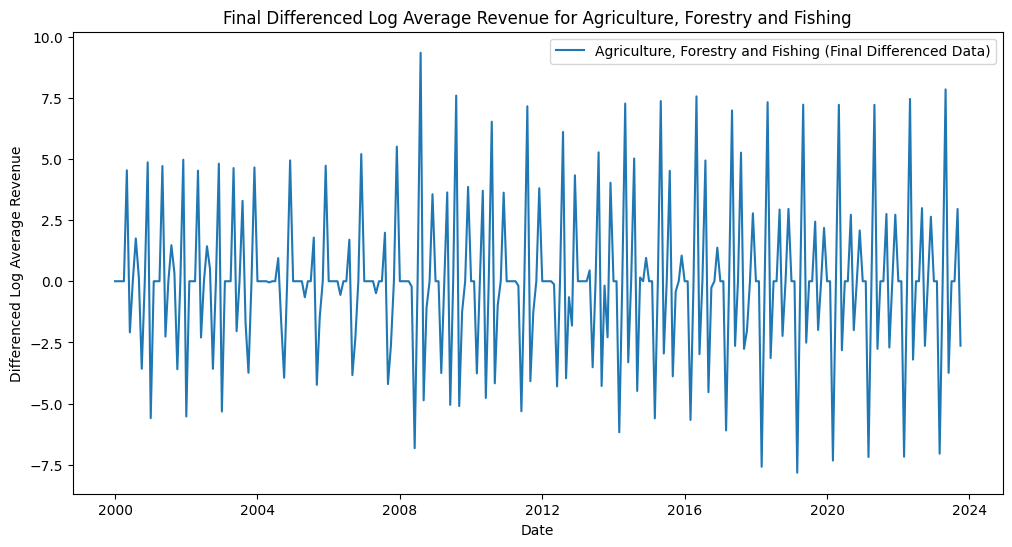

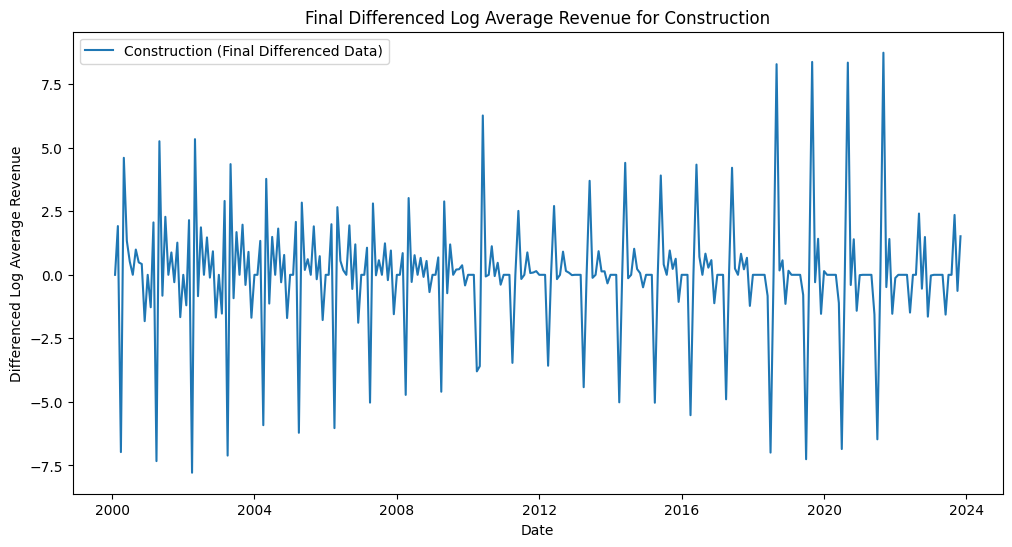

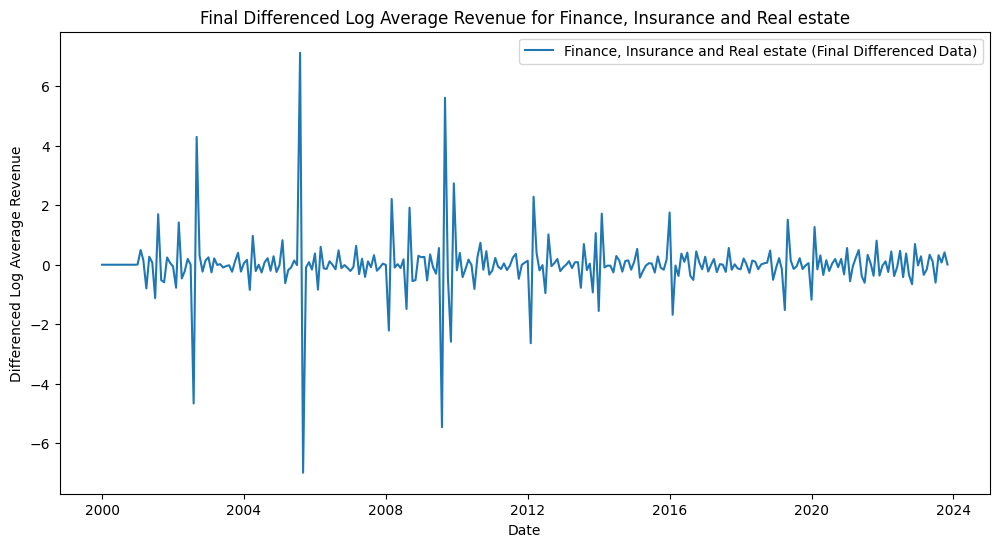

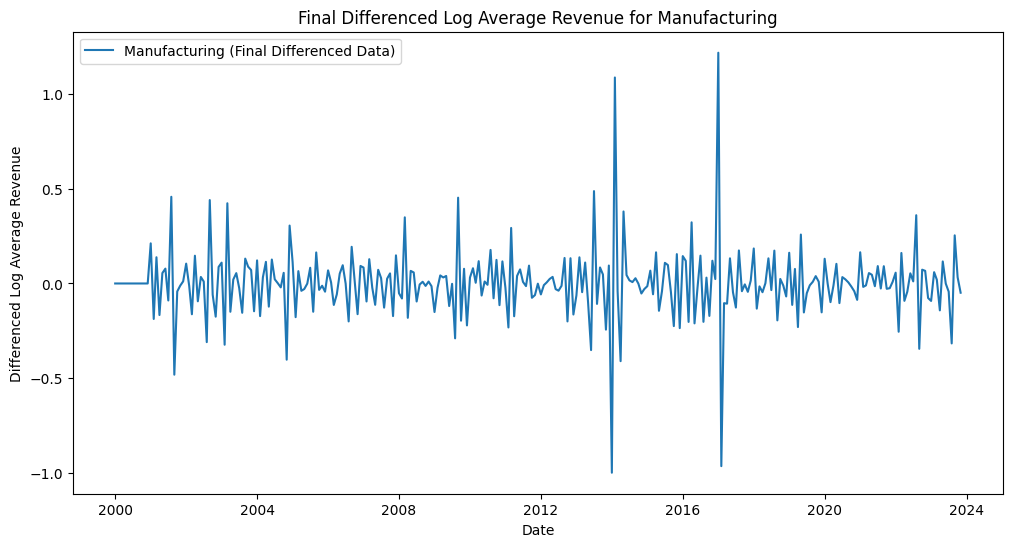

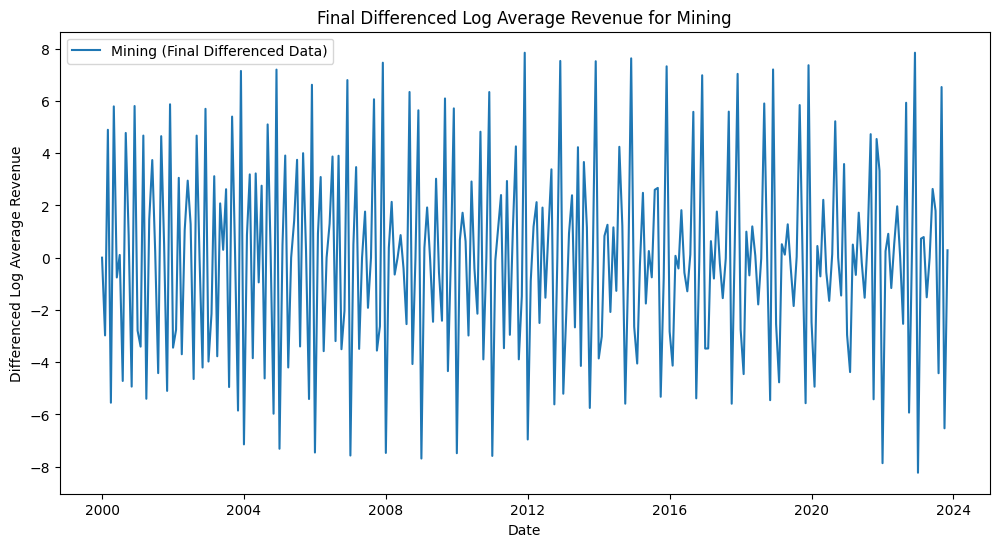

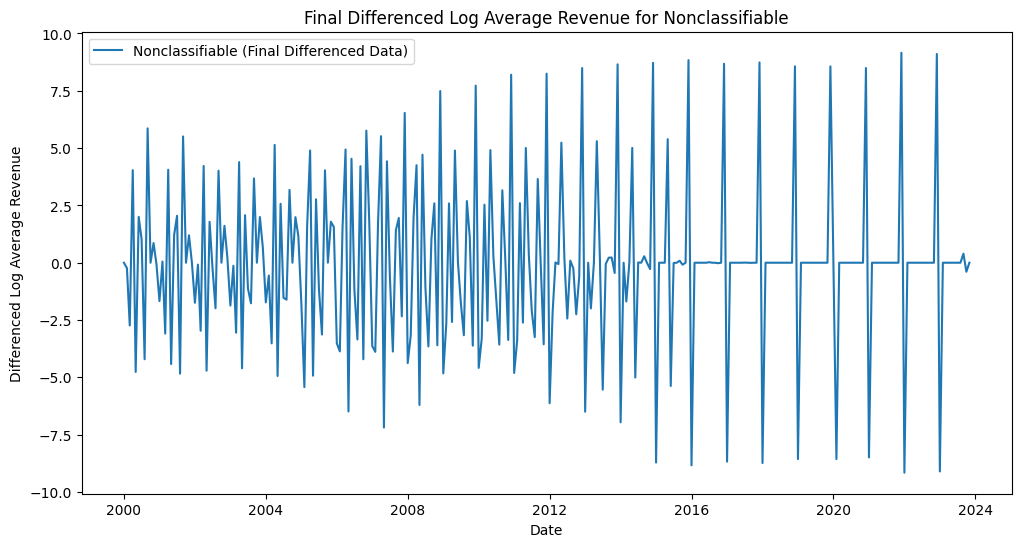

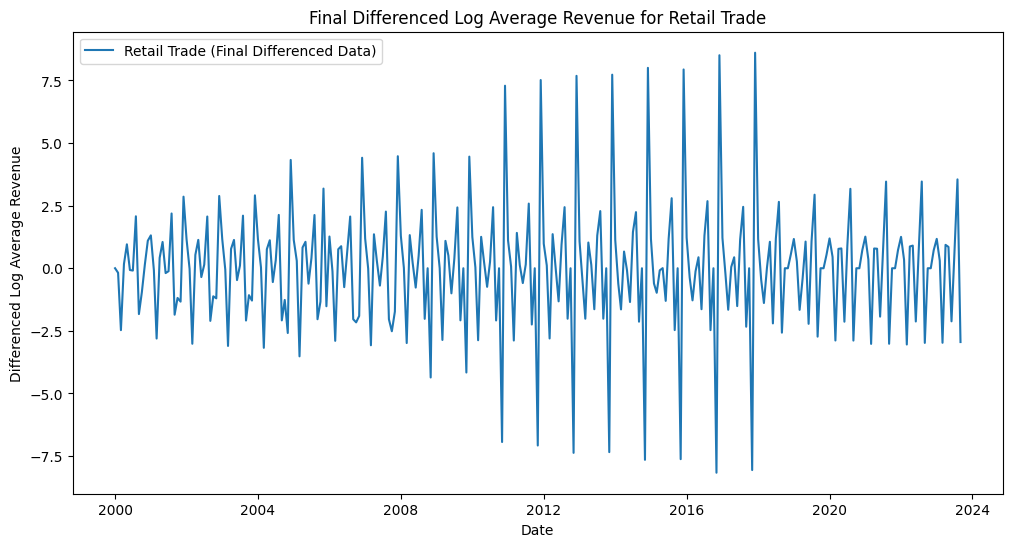

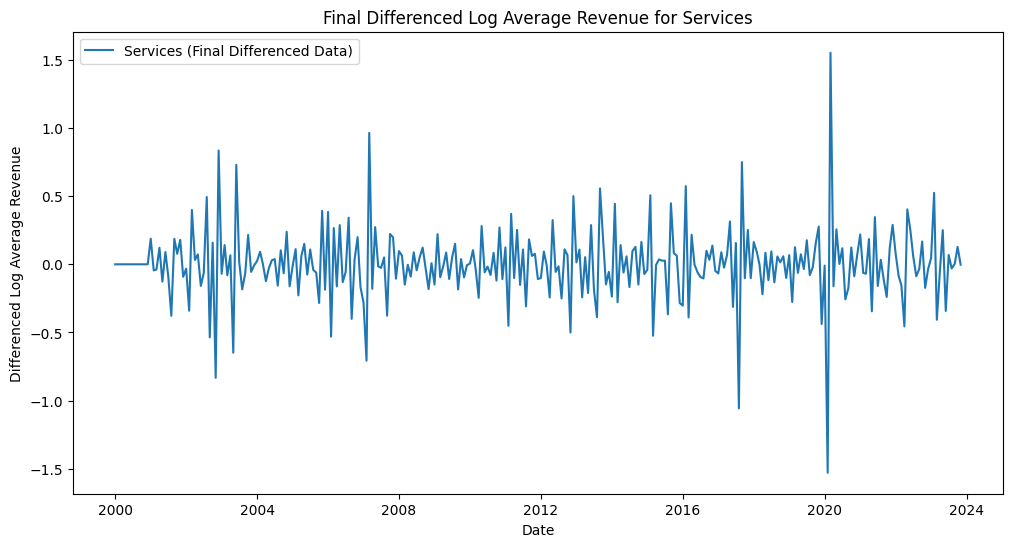

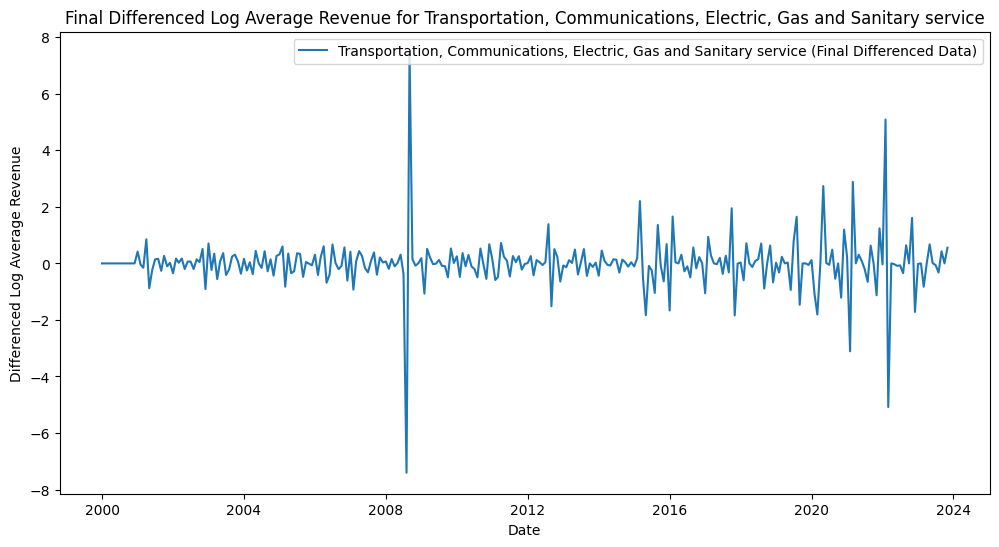

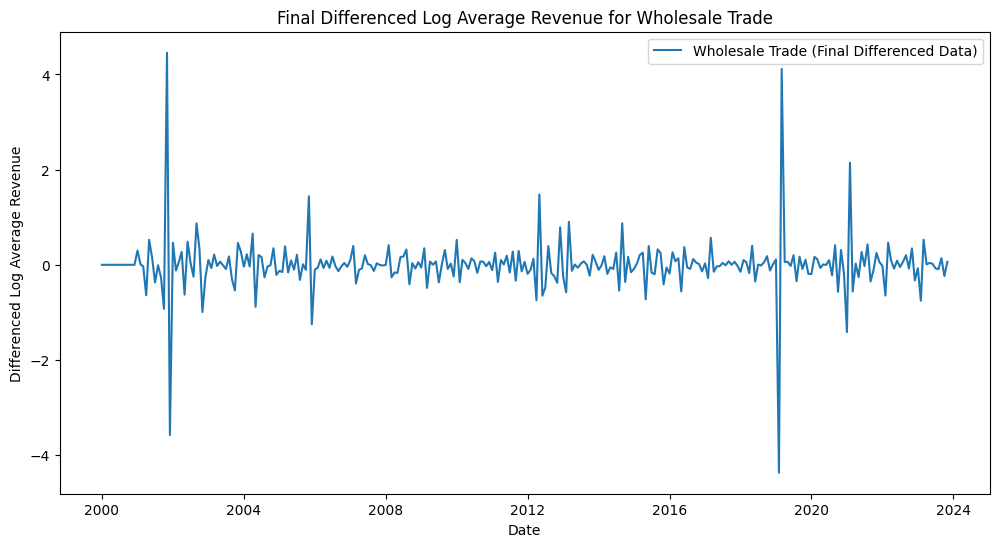

In [27]:
from pmdarima.arima.utils import ndiffs, nsdiffs
import matplotlib.pyplot as plt
import pandas as pd

# Define a function to apply differencing for each group
def difference_data(group, division_name, seasonal_period=12):  
    # Drop rows with NaN in 'log_avg_revenue' (if any)
    group = group.copy()  # Avoid modifying original data
    group['log_avg_revenue'] = group['log_avg_revenue'].fillna(0)  # Fill NaNs to avoid issues

    # Step 1: Check for seasonal differences
    try:
        D = nsdiffs(group['log_avg_revenue'], m=seasonal_period, test='ocsb')  
    except ValueError:
        D = 0  # Default to no seasonal differencing if NaN issues persist

    print(f"Division: {division_name}, Optimal number of seasonal differences (D): {D}")

    # Step 2: Apply seasonal differences 
    if D > 0:
        group['log_avg_revenue_seasonal_diff'] = group['log_avg_revenue'].diff(periods=seasonal_period * D).fillna(0)
    else:
        group['log_avg_revenue_seasonal_diff'] = group['log_avg_revenue']  

    # Step 3: Check for regular differences
    try:
        d = ndiffs(group['log_avg_revenue_seasonal_diff'].dropna(), test='adf')  
    except ValueError:
        d = 0  # Default to no differencing if an error occurs

    print(f"Division: {division_name}, Optimal number of regular differences (d): {d}")

    # Step 4: Apply regular differences
    if d > 0:
        group['log_avg_revenue_final_diff'] = group['log_avg_revenue_seasonal_diff'].diff(periods=d).fillna(0)
    else:
        group['log_avg_revenue_final_diff'] = group['log_avg_revenue_seasonal_diff'].diff(periods=1).fillna(0)

    return group

# Apply the differencing function to each group
result = (
    division_monthly_avg
    .groupby('division')
    .apply(lambda x: difference_data(x, x.name))  
)

# Reset the index (optional)
result = result.reset_index(drop=True)

# Display the final DataFrame
print(result)

# Step 5: Plot the final differenced data for each division
for division, group in result.groupby('division'):
    plt.figure(figsize=(12, 6))
    plt.plot(group['year_month'], group['log_avg_revenue_final_diff'], label=f'{division} (Final Differenced Data)')
    plt.title(f'Final Differenced Log Average Revenue for {division}')
    plt.xlabel('Date')
    plt.ylabel('Differenced Log Average Revenue')
    plt.legend()
    plt.show()


In [28]:
# Augmented Dickey fuller test for unit root 
from statsmodels.tsa.stattools import adfuller

def perform_adf_test(data, column, group_by='division', min_obs=20):
    """
    Perform ADF test group-wise and handle exceptions (inf, nan, constant values, short series).
    """
    adf_results = {}

    for group_name, group_data in data.groupby(group_by):
        # Clean and validate the series
        series = (
            group_data[column]
            .replace([np.inf, -np.inf], np.nan)
            .dropna()
        )

        # Skip if not enough data points
        if len(series) < min_obs:
            adf_results[group_name] = {
                'ADF Statistic': None,
                'p-value': None,
                'Critical Values': None,
                'Stationary?': 'Insufficient data'
            }
            continue

        # Skip if constant series (ADF will fail)
        if series.nunique() <= 1:
            adf_results[group_name] = {
                'ADF Statistic': None,
                'p-value': None,
                'Critical Values': None,
                'Stationary?': 'Constant series'
            }
            continue

        # Try ADF and catch any errors
        try:
            adf_test = adfuller(series)
            adf_results[group_name] = {
                'ADF Statistic': adf_test[0],
                'p-value': adf_test[1],
                'Critical Values': adf_test[4],
                'Stationary?': 'Yes' if adf_test[1] < 0.05 else 'No'
            }
        except Exception as e:
            adf_results[group_name] = {
                'ADF Statistic': None,
                'p-value': None,
                'Critical Values': None,
                'Stationary?': f'Error: {str(e)}'
            }

    return pd.DataFrame(adf_results).T

# Example Usage
perform_adf_test(result, column='log_avg_revenue_final_diff')

ADF Statistic p-value  \
Agriculture, Forestry and Fishing                      -6.040387     0.0   
Construction                                           -10.16414     0.0   
Finance, Insurance and Real estate                      -9.34224     0.0   
Manufacturing                                          -11.53836     0.0   
Mining                                                -28.755192     0.0   
Nonclassifiable                                       -15.716623     0.0   
Retail Trade                                          -24.543066     0.0   
Services                                               -8.780057     0.0   
Transportation, Communications, Electric, Gas a...     -9.497773     0.0   
Wholesale Trade                                        -9.930978     0.0   

                                                                                      Critical Values  \
Agriculture, Forestry and Fishing                   {'1%': -3.4548039258751206, '5%': -2.872304928...   
Construction                                        {'1%': -3.4546223782586534, '5%': -2.872225321...   
Finance, Insurance and Real estate                  {'1%': -3.4540935579190495, '5%': -2.871993411...   
Manufacturing                                       {'1%': -3.4538376962008495, '5%': -2.871881191...   
Mining                                              {'1%': -3.4542672521624214, '5%': -2.872069587...   
Nonclassifiable                                     {'1%': -3.454355055831705, '5%': -2.8721080938...   
Retail Trade                                        {'1%': -3.4544435065994437, '5%': -2.872146882...   
Services                                            {'1%': -3.4542672521624214, '5%': -2.872069587...   
Transportation, Communications, Electric, Gas a...  {'1%': -3.4541800885158525, '5%': -2.872031361...   
Wholesale Trade                                     {'1%': -3.4541800885158525, '5%': -2.872031361...   

                                                   Stationary?  
Agriculture, Forestry and Fishing                          Yes  
Construction                                               Yes  
Finance, Insurance and Real estate                         Yes  
Manufacturing                                              Yes  
Mining                                                     Yes  
Nonclassifiable                                            Yes  
Retail Trade                                               Yes  
Services                                                   Yes  
Transportation, Communications, Electric, Gas a...         Yes  
Wholesale Trade                                            Yes

In [12]:
result

division year_month  avg_monthly_revenue  \
0     Agriculture, Forestry and Fishing 2000-01-01               3.0960   
1     Agriculture, Forestry and Fishing 2000-02-01               3.0960   
2     Agriculture, Forestry and Fishing 2000-03-01               3.0960   
3     Agriculture, Forestry and Fishing 2000-04-01               3.0960   
4     Agriculture, Forestry and Fishing 2000-05-01             288.0550   
...                                 ...        ...                  ...   
2861                    Wholesale Trade 2023-07-01           15969.9925   
2862                    Wholesale Trade 2023-08-01           10572.0392   
2863                    Wholesale Trade 2023-09-01           53500.1156   
2864                    Wholesale Trade 2023-10-01             502.7770   
2865                    Wholesale Trade 2023-11-01           28796.8465   

      log_avg_revenue  log_avg_revenue_seasonal_diff  \
0            1.130111                       1.130111   
1            1.130111                       1.130111   
2            1.130111                       1.130111   
3            1.130111                       1.130111   
4            5.663151                       5.663151   
...               ...                            ...   
2861         9.678467                       0.046150   
2862         9.265968                      -0.045662   
2863        10.887439                       0.093936   
2864         6.220147                      -0.142640   
2865        10.268021                      -0.080116   

      log_avg_revenue_final_diff  
0                       0.000000  
1                       0.000000  
2                       0.000000  
3                       0.000000  
4                       4.533040  
...                          ...  
2861                   -0.073267  
2862                   -0.091811  
2863                    0.139598  
2864                   -0.236577  
2865                    0.062525  

[2866 rows x 6 columns]

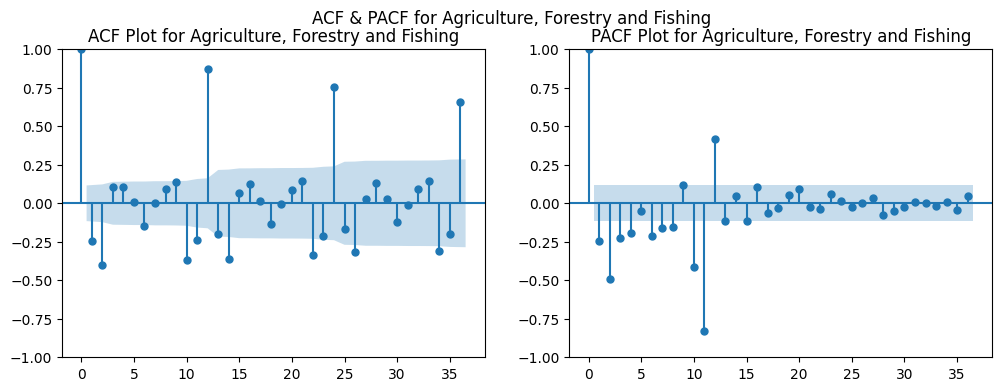

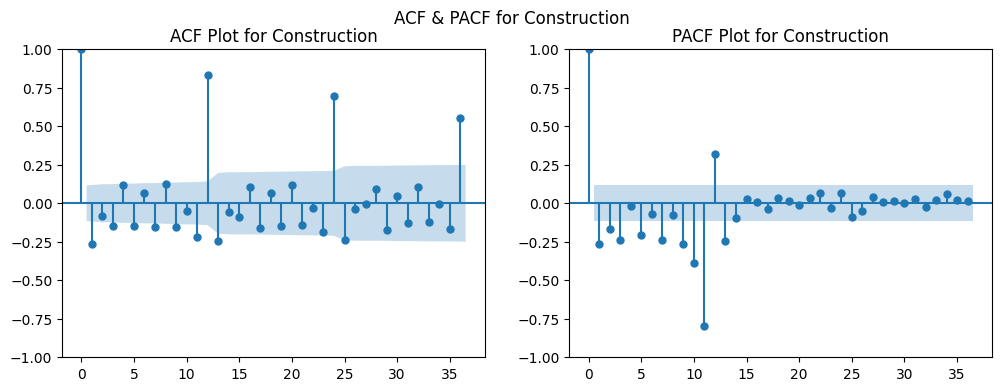

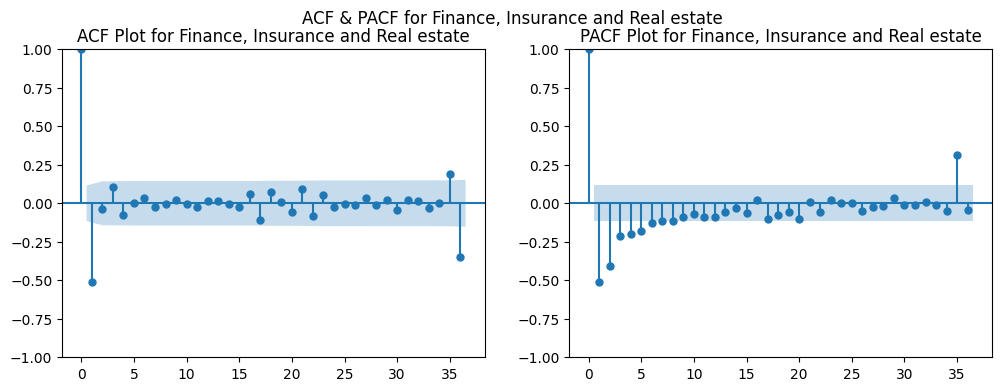

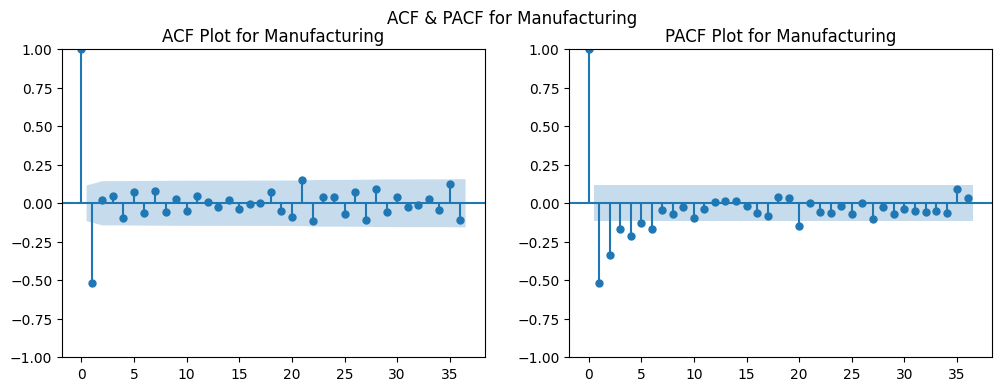

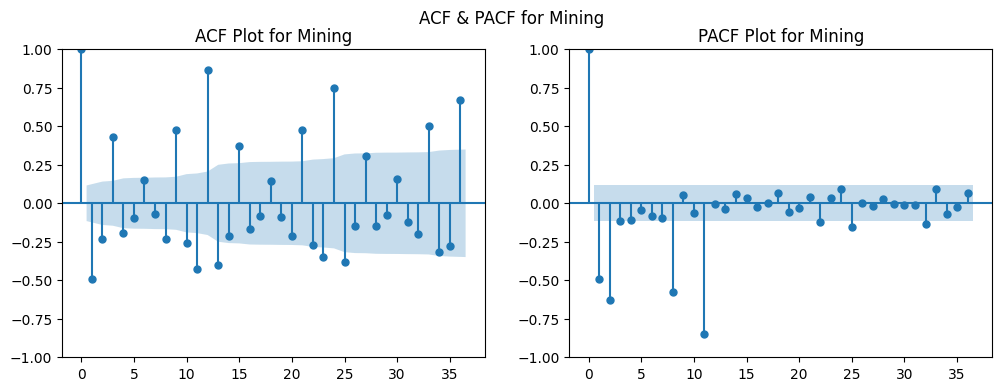

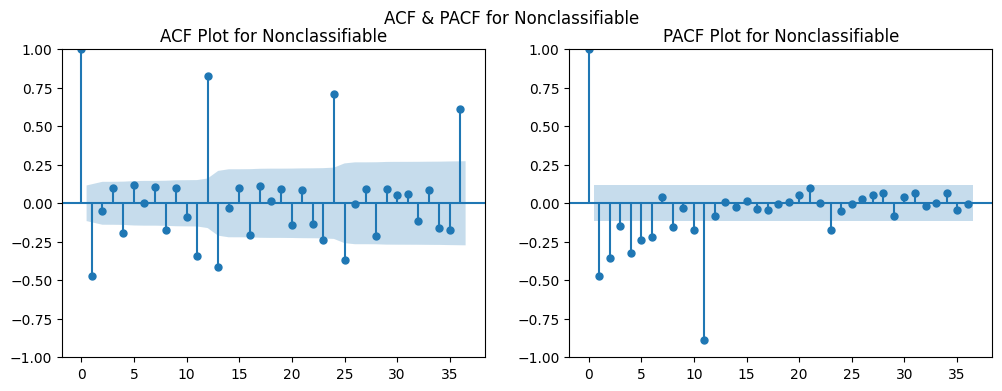

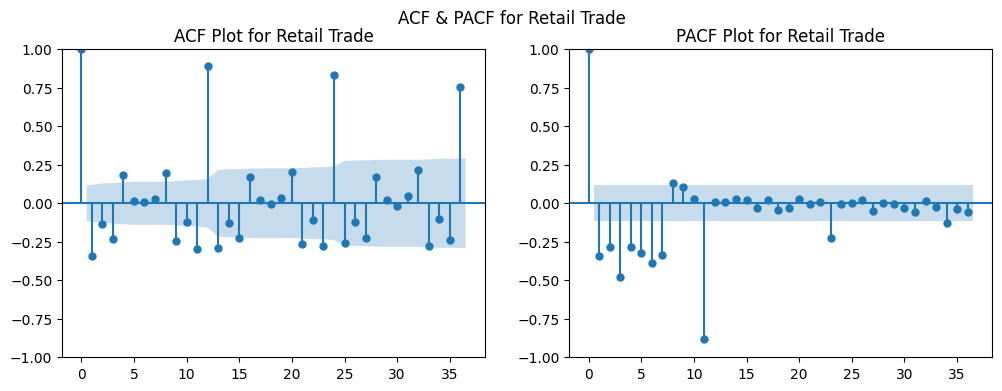

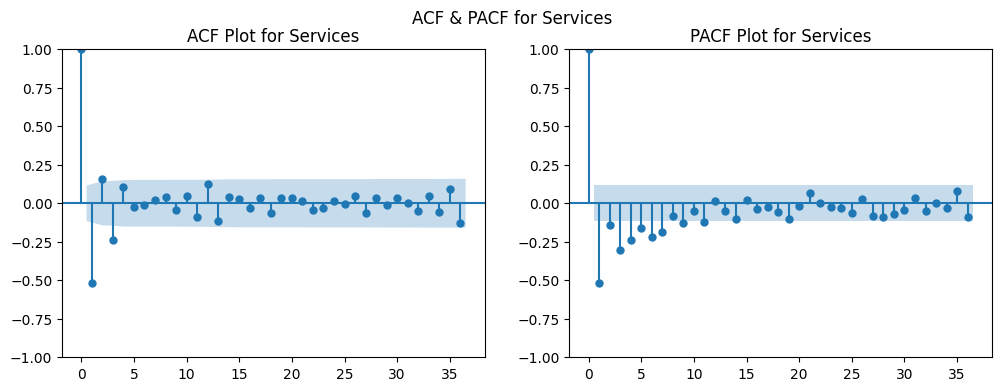

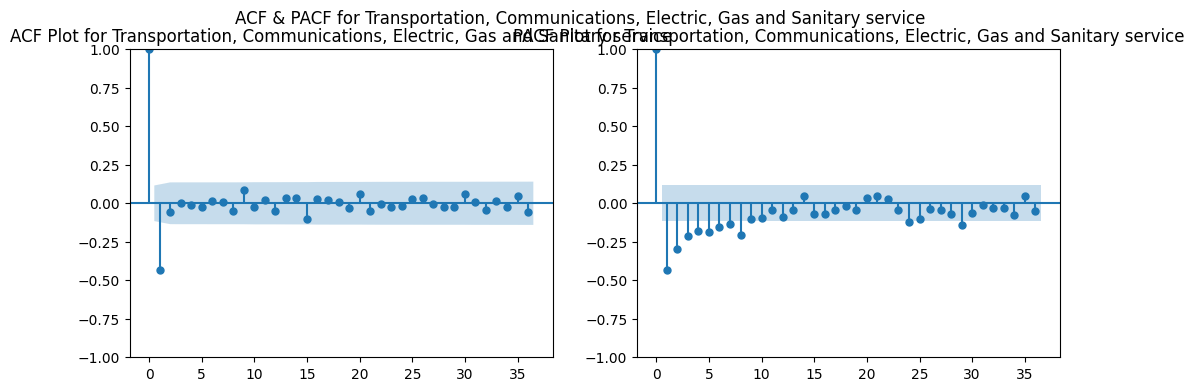

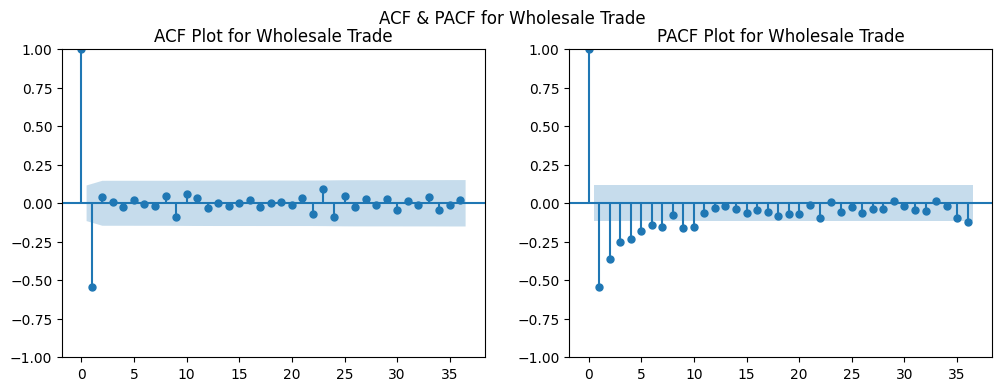

In [29]:
for division, group in result.groupby('division'):
    series = group['log_avg_revenue_final_diff'].dropna()
    
    # Create ACF and PACF plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # ACF Plot
    sm.graphics.tsa.plot_acf(series, lags=36, ax=axes[0])
    axes[0].set_title(f'ACF Plot for {division}')
    
    # PACF Plot
    sm.graphics.tsa.plot_pacf(series, lags=36, ax=axes[1], method="ols")  # Use "ols" for stability
    axes[1].set_title(f'PACF Plot for {division}')
    
    plt.suptitle(f'ACF & PACF for {division}')
    plt.show()
    
    # ACF suggest that there is seasonality seen in the ACF, strong autocorrelation

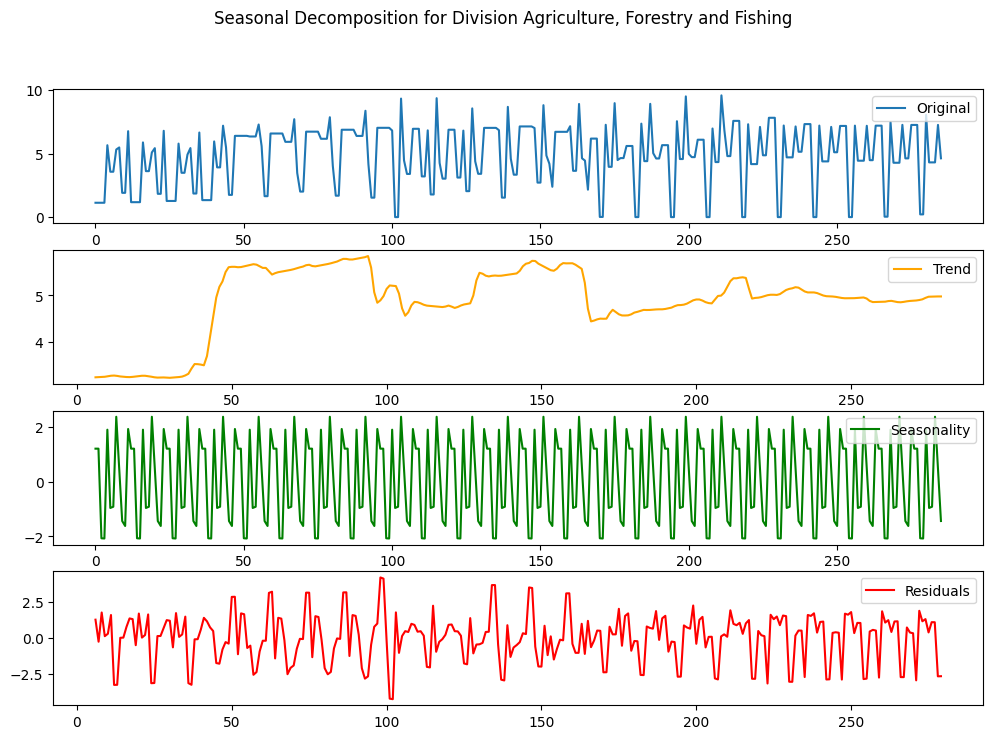

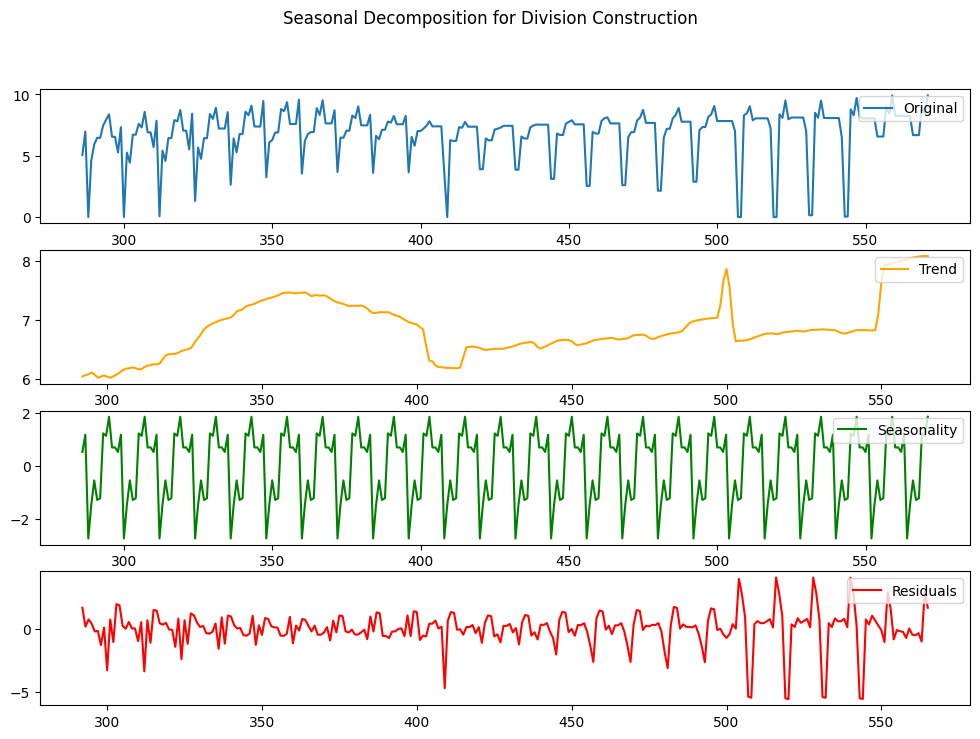

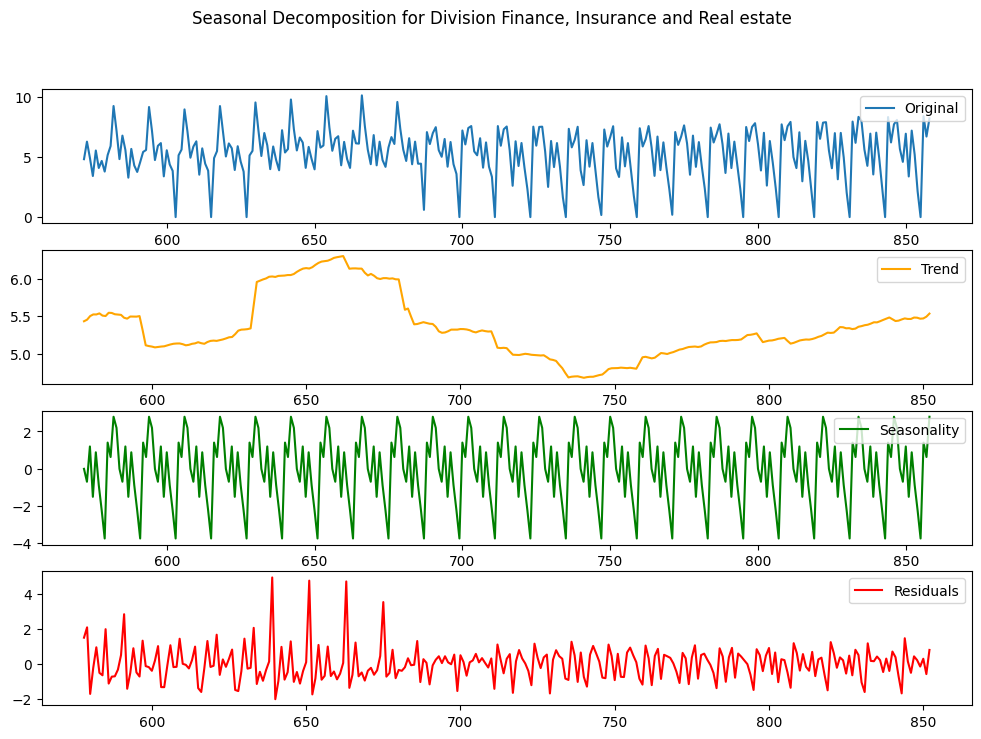

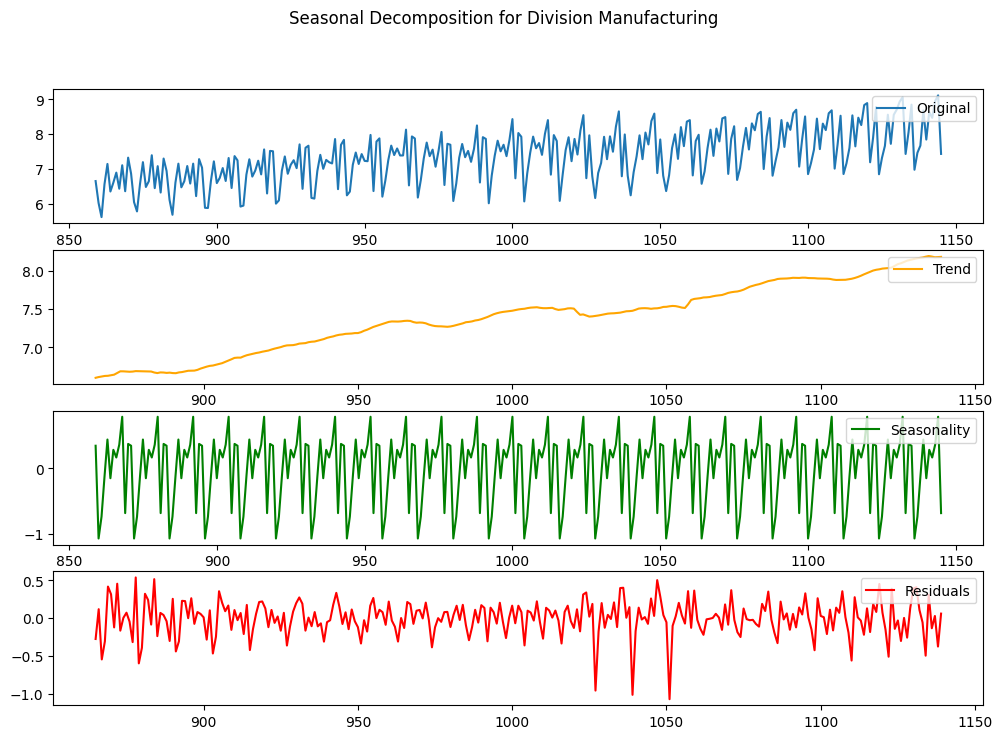

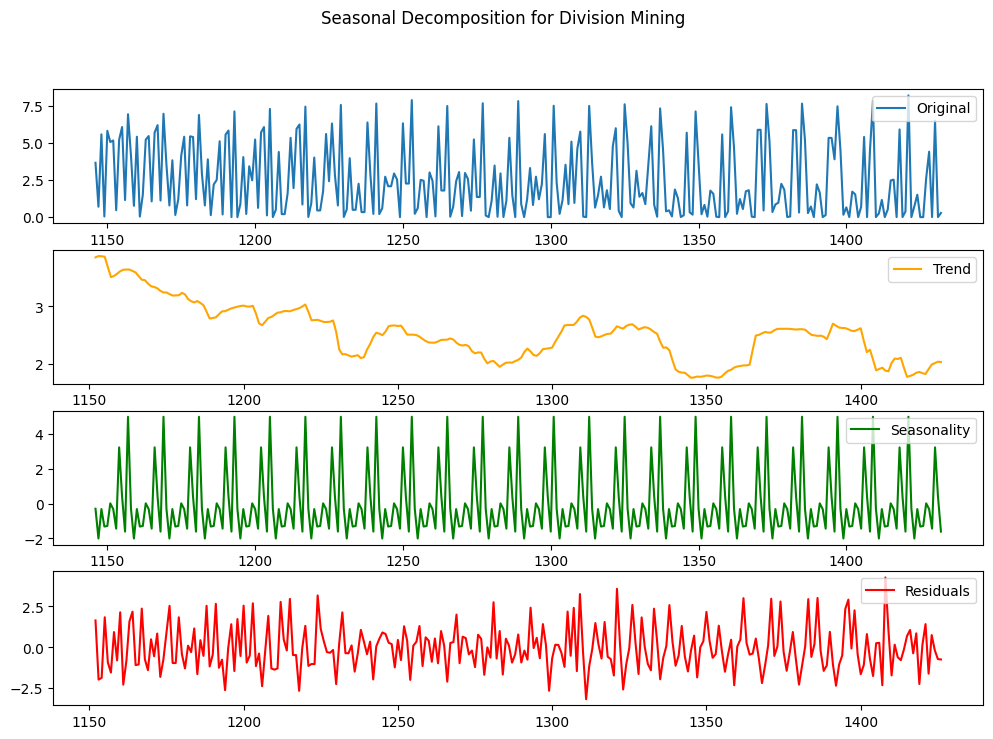

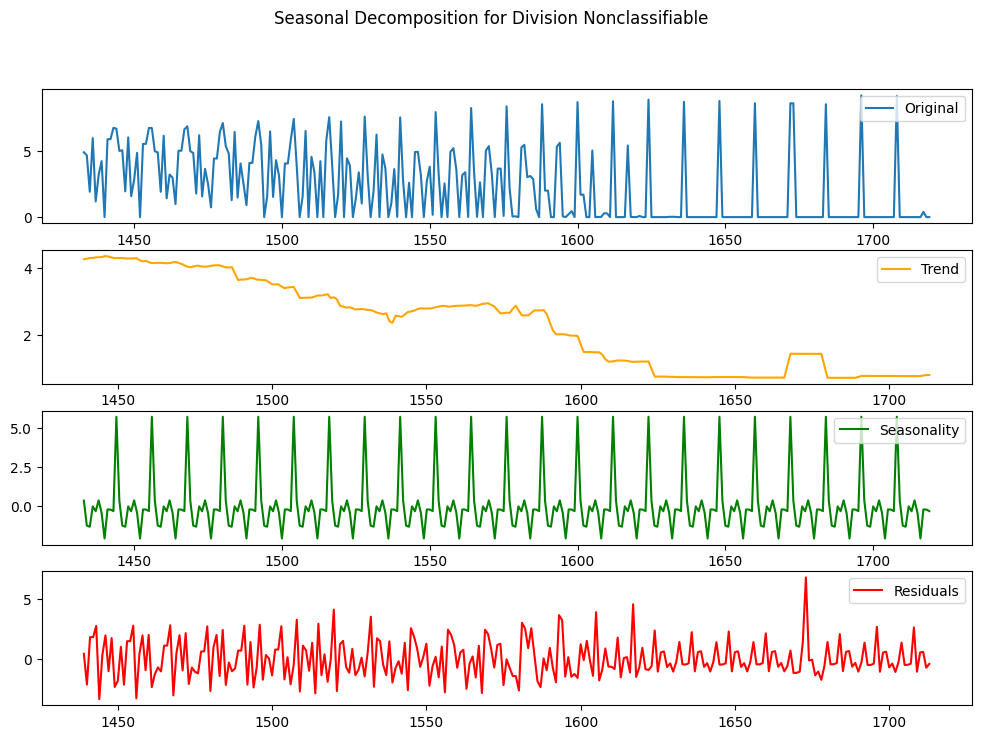

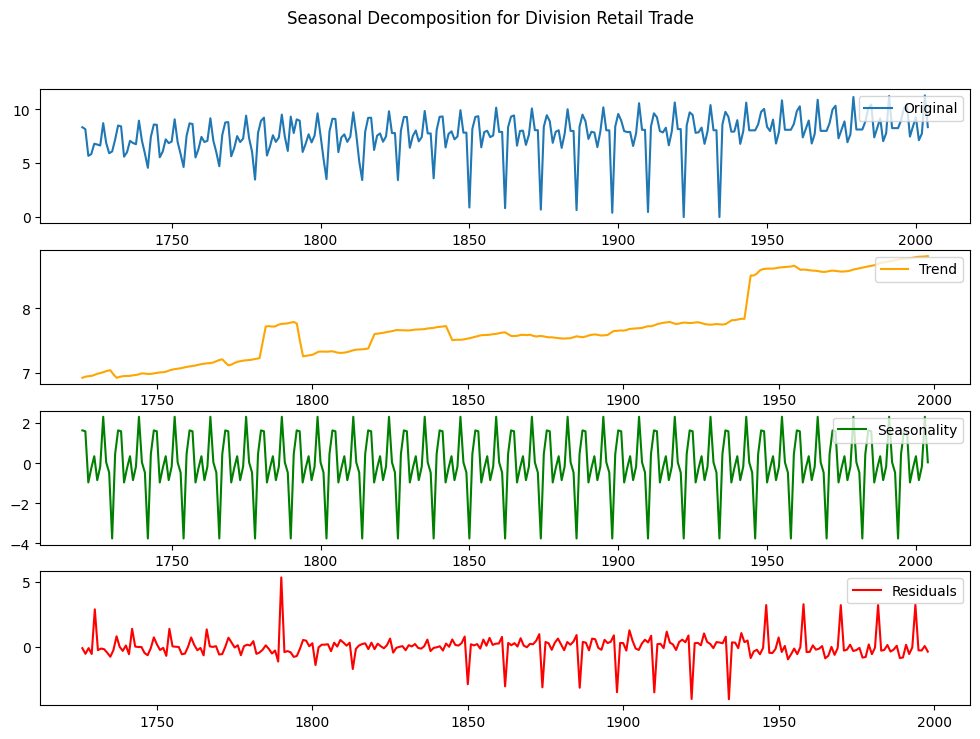

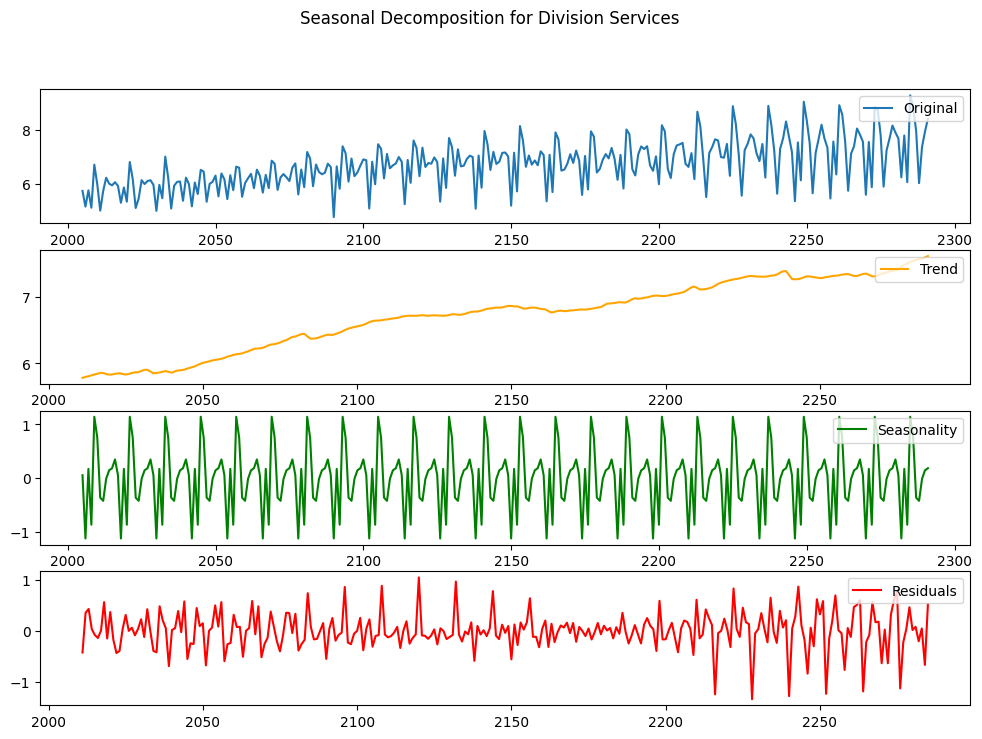

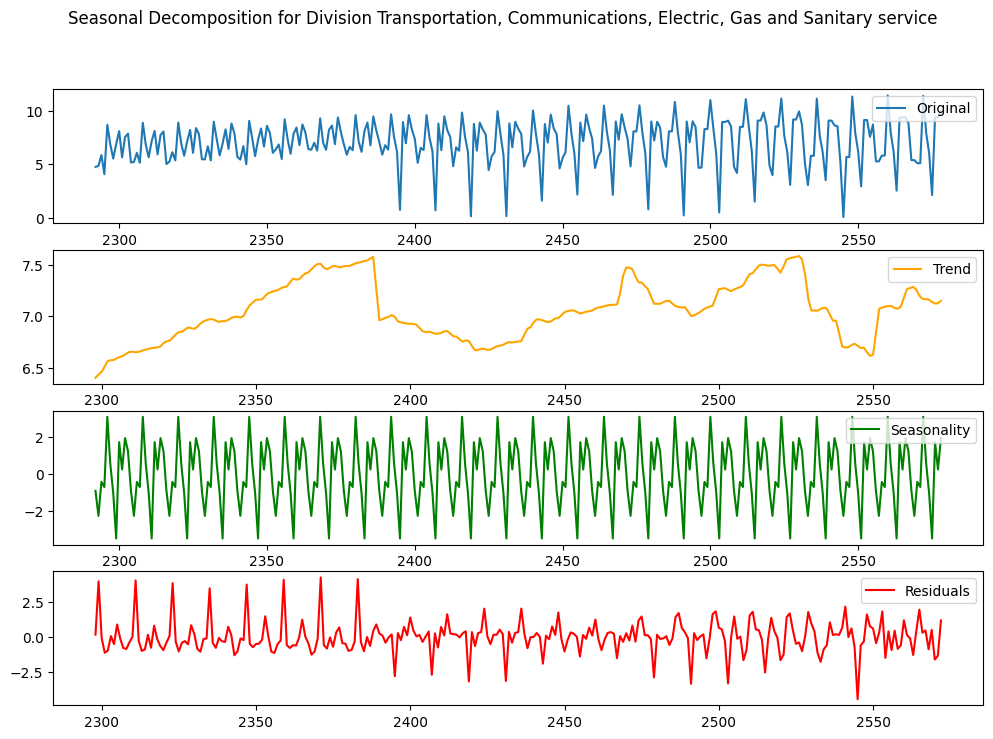

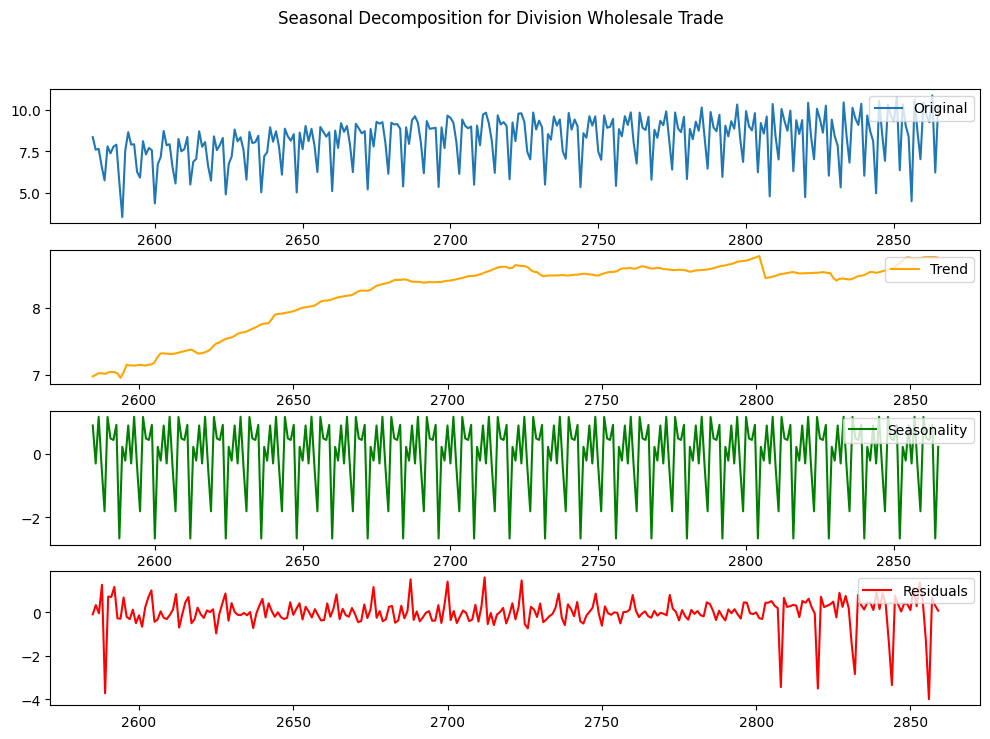

/var/folders/f7/13y631vn2pgcf1cfnl1t2vgh0000gn/T/ipykernel_61796/932990447.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  division_monthly_avg = division_monthly_avg.groupby('division', group_keys=False).apply(decompose_per_division)


In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Perform seasonal decomposition per division
def decompose_per_division(group):
    if len(group) < 12:  # Ensure enough data for decomposition
        return None
    decomposition = seasonal_decompose(group['log_avg_revenue'], period=12, model='additive')
    group['seasonal'] = decomposition.seasonal.dropna()
    group['trend'] = decomposition.trend.dropna()
    group['residual'] = decomposition.resid.dropna()
    
    plt.figure(figsize=(12, 8))
    plt.suptitle(f"Seasonal Decomposition for Division {group['division'].iloc[0]}")
    
    plt.subplot(411)
    plt.plot(decomposition.observed, label='Original')
    plt.legend(loc='upper right')
    
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend', color='orange')
    plt.legend(loc='upper right')
    
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonality', color='green')
    plt.legend(loc='upper right')
    
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals', color='red')
    plt.legend(loc='upper right')
    
    plt.show()
    return group

division_monthly_avg = division_monthly_avg.groupby('division', group_keys=False).apply(decompose_per_division)

In [59]:
division_monthly_avg

division year_month  avg_monthly_revenue  \
0     Agriculture, Forestry and Fishing 2000-01-01               3.0960   
1     Agriculture, Forestry and Fishing 2000-02-01               3.0960   
2     Agriculture, Forestry and Fishing 2000-03-01               3.0960   
3     Agriculture, Forestry and Fishing 2000-04-01               3.0960   
4     Agriculture, Forestry and Fishing 2000-05-01             288.0550   
...                                 ...        ...                  ...   
2861                    Wholesale Trade 2023-07-01           15969.9925   
2862                    Wholesale Trade 2023-08-01           10572.0392   
2863                    Wholesale Trade 2023-09-01           53500.1156   
2864                    Wholesale Trade 2023-10-01             502.7770   
2865                    Wholesale Trade 2023-11-01           28796.8465   

      log_avg_revenue  seasonal  trend  residual  
0            1.130111  1.167658    NaN       NaN  
1            1.130111  1.168158    NaN       NaN  
2            1.130111 -2.072560    NaN       NaN  
3            1.130111 -2.080703    NaN       NaN  
4            5.663151  1.911579    NaN       NaN  
...               ...       ...    ...       ...  
2861         9.678467  0.497204    NaN       NaN  
2862         9.265968  0.448424    NaN       NaN  
2863        10.887439  0.926262    NaN       NaN  
2864         6.220147 -2.665605    NaN       NaN  
2865        10.268021  0.230430    NaN       NaN  

[2866 rows x 7 columns]

In [31]:
# Merge the log_avg_revenue_final_diff column from result into division_monthly_avg
division_monthly_avg = division_monthly_avg.merge(
    result[['division', 'year_month', 'log_avg_revenue_final_diff']],
    on=['division', 'year_month'],
    how='left'
)

split data into test and train

In [32]:
# Initialize empty DataFrames for training and testing
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# Loop through each division and split the data
for division, group_data in division_monthly_avg.groupby('division'):
    # Calculate the split point for this division
    split_point = int(len(group_data) * 0.8)
    
    # Split into training and testing
    train_data = pd.concat([train_data, group_data[:split_point]])
    test_data = pd.concat([test_data, group_data[split_point:]])

# Reset indices for the new DataFrames
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

print(f"Training data: {len(train_data)} rows")
print(f"Test data: {len(test_data)} rows")

Training data: 2287 rows
Test data: 579 rows


In [62]:
train_data.head()

division year_month  avg_monthly_revenue  \
0  Agriculture, Forestry and Fishing 2000-01-01                3.096   
1  Agriculture, Forestry and Fishing 2000-02-01                3.096   
2  Agriculture, Forestry and Fishing 2000-03-01                3.096   
3  Agriculture, Forestry and Fishing 2000-04-01                3.096   
4  Agriculture, Forestry and Fishing 2000-05-01              288.055   

   log_avg_revenue  seasonal  trend  residual  log_avg_revenue_final_diff  
0         1.130111  1.167658    NaN       NaN                     0.00000  
1         1.130111  1.168158    NaN       NaN                     0.00000  
2         1.130111 -2.072560    NaN       NaN                     0.00000  
3         1.130111 -2.080703    NaN       NaN                     0.00000  
4         5.663151  1.911579    NaN       NaN                     4.53304

Fit a naive model on trend, seasonal naive on seasonal component after decomposition

In [33]:
# Initialize dictionaries to store decomposed components and forecasts for each division
decompositions = {}
forecasts = {}

# Loop through each division in the training data
for division in train_data['division'].unique():
    # Get the training data for this division
    division_train = train_data[train_data['division'] == division]
    division_test = test_data[test_data['division'] == division]
    
    # Decompose the time series for this division
    try:
        decomposition = seasonal_decompose(division_train['log_avg_revenue'], period=12)
        
        # Store decomposition results
        decompositions[division] = decomposition
        
        # Extract components and drop NaN values
        seasonal_component = decomposition.seasonal.dropna()
        trend_cycle_component = decomposition.trend.dropna()
        residual_component = decomposition.resid.dropna()
        
        # Create naive forecasts
        # Trend forecast: last observed trend value
        last_trend_value = trend_cycle_component.iloc[-1]
        
        # Seasonal forecast: repeat the last observed seasonal pattern
        seasonal_pattern = seasonal_component.iloc[-12:]
        
        # Repeat the seasonal pattern for the test period
        repeated_seasonal = pd.Series(index=division_test.index)
        for i in range(len(division_test)):
            repeated_seasonal.iloc[i] = seasonal_pattern.iloc[i % 12]
        
        # Combine trend and seasonal forecasts
        extended_forecast = last_trend_value + repeated_seasonal
        
        # Store the forecast
        forecasts[division] = extended_forecast
        
        # Assign to test_data DataFrame
        test_data.loc[test_data['division'] == division, 'classical_naive_forecast'] = extended_forecast.values
        
    except Exception as e:
        print(f"Error decomposing {division}: {str(e)}")
        continue

# Now test_data contains forecasts for each division
print(test_data[['division', 'log_avg_revenue', 'classical_naive_forecast']])

                              division  log_avg_revenue  \
0    Agriculture, Forestry and Fishing         7.825224   
1    Agriculture, Forestry and Fishing         7.825224   
2    Agriculture, Forestry and Fishing              0.0   
3    Agriculture, Forestry and Fishing              0.0   
4    Agriculture, Forestry and Fishing         7.216848   
..                                 ...              ...   
574                    Wholesale Trade         9.678467   
575                    Wholesale Trade         9.265968   
576                    Wholesale Trade        10.887439   
577                    Wholesale Trade         6.220147   
578                    Wholesale Trade        10.268021   

     classical_naive_forecast  
0                    5.832116  
1                    5.833382  
2                    3.685553  
3                    3.674963  
4                    6.762269  
..                        ...  
574                  9.188998  
575                  9.254516  
576

In [34]:
# Initialize dictionaries to store decomposed components and forecasts for each division
stl_decompositions = {}
stl_forecasts = {}

# Loop through each division in the training data
for division in train_data['division'].unique():
    # Get the training and test data for this division
    division_train = train_data[train_data['division'] == division]
    division_test = test_data[test_data['division'] == division]
    
    # Perform STL decomposition for this division
    try:
        stl = STL(division_train['log_avg_revenue'], period=12)  # Assuming 252 trading days/year
        decomposition = stl.fit()
        
        # Store decomposition results
        stl_decompositions[division] = decomposition
        
        # Extract components and drop NaN values
        seasonal_component = decomposition.seasonal.dropna()
        trend_cycle_component = decomposition.trend.dropna()
        residual_component = decomposition.resid.dropna()
        
        # Create naive forecasts
        # Trend forecast: last observed trend value
        last_trend_value = trend_cycle_component.iloc[-1]
        
        # Seasonal forecast: repeat the last observed seasonal pattern
        seasonal_pattern = seasonal_component.iloc[-12:]
        
        # Repeat the seasonal pattern for the test period
        repeated_seasonal = pd.Series(index=division_test.index)
        for i in range(len(division_test)):
            repeated_seasonal.iloc[i] = seasonal_pattern.iloc[i % 12]
        
        # Combine trend and seasonal forecasts
        extended_forecast = last_trend_value + repeated_seasonal
        
        # Store the forecast
        stl_forecasts[division] = extended_forecast
        
        # Assign to test_data DataFrame
        test_data.loc[test_data['division'] == division, 'stl_naive_forecast'] = extended_forecast.values
        
    except Exception as e:
        print(f"Error with STL decomposition for {division}: {str(e)}")
        continue

# Now test_data contains STL forecasts for each division
print(test_data[['division', 'log_avg_revenue', 'stl_naive_forecast']])

                              division  log_avg_revenue  stl_naive_forecast
0    Agriculture, Forestry and Fishing         7.825224            6.380510
1    Agriculture, Forestry and Fishing         7.825224            6.409092
2    Agriculture, Forestry and Fishing              0.0           -0.776782
3    Agriculture, Forestry and Fishing              0.0           -0.758986
4    Agriculture, Forestry and Fishing         7.216848            6.742471
..                                 ...              ...                 ...
574                    Wholesale Trade         9.678467            9.142782
575                    Wholesale Trade         9.265968            8.828321
576                    Wholesale Trade        10.887439            9.943909
577                    Wholesale Trade         6.220147            6.313018
578                    Wholesale Trade        10.268021            9.272273

[579 rows x 3 columns]


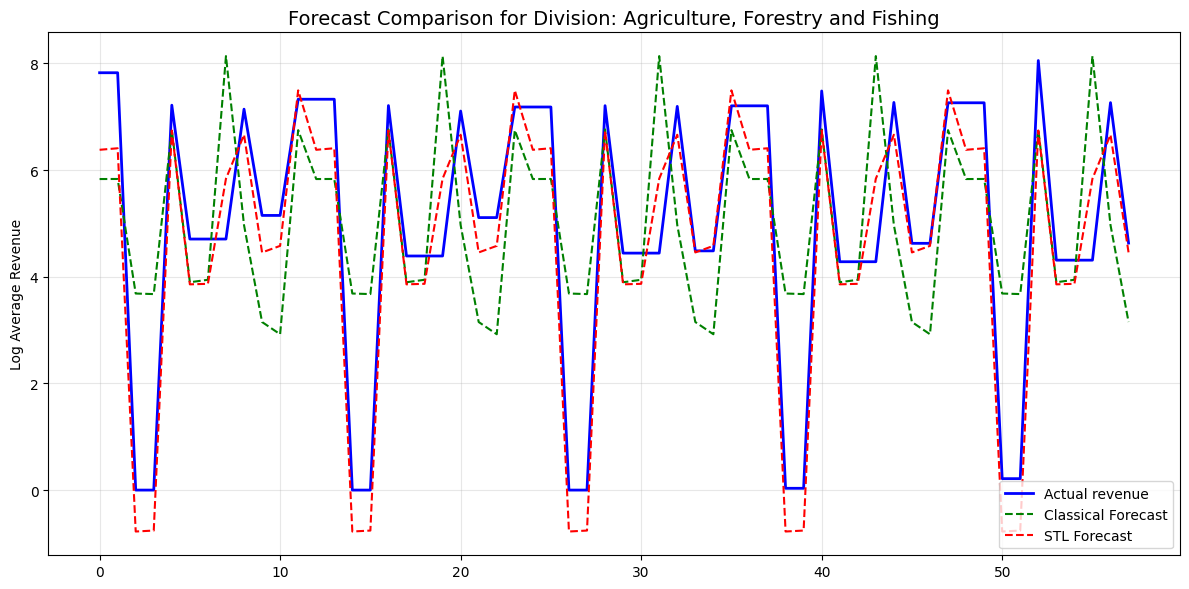

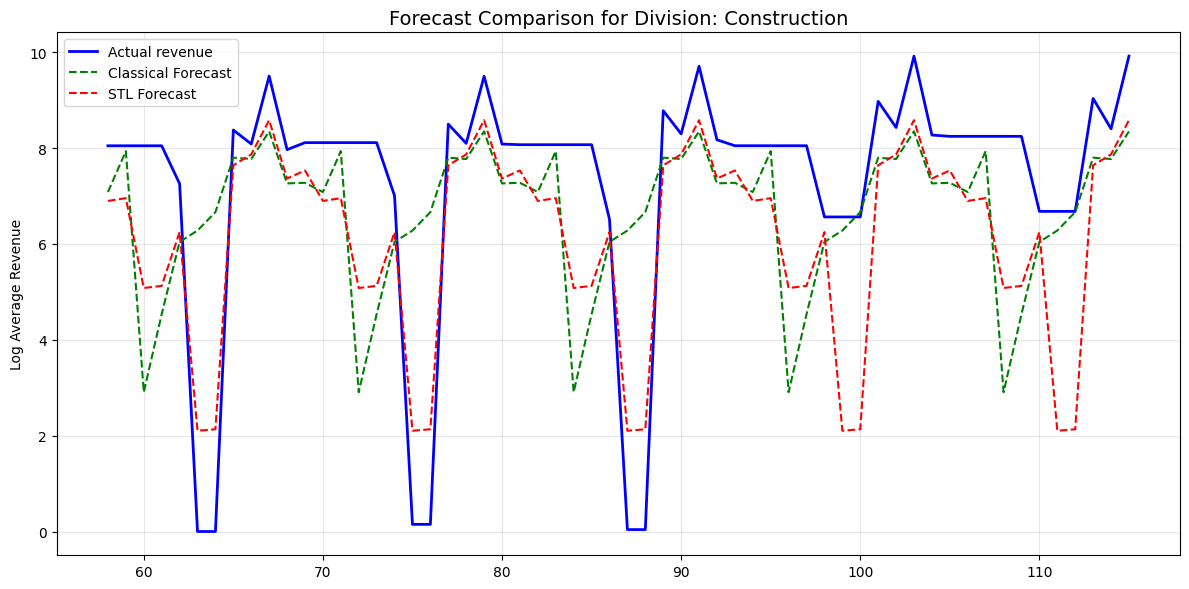

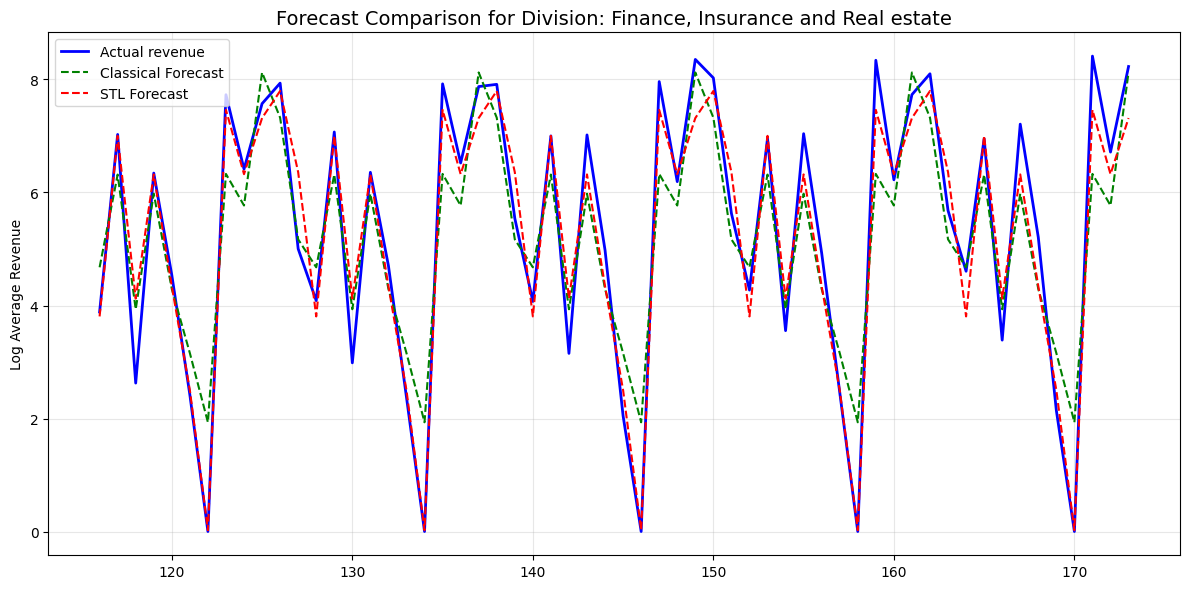

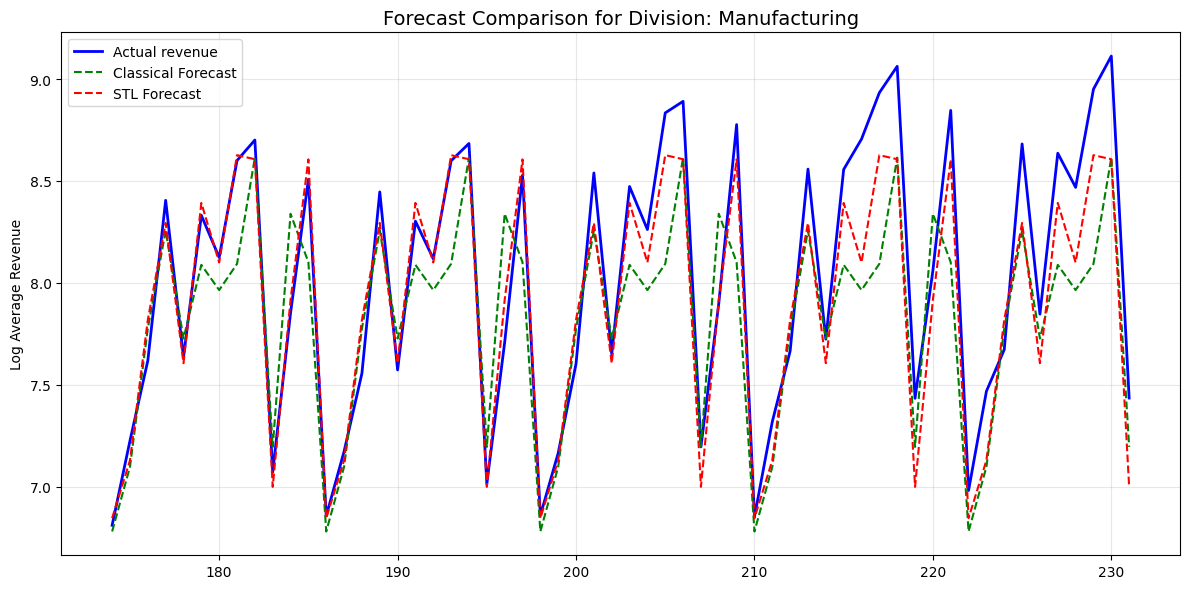

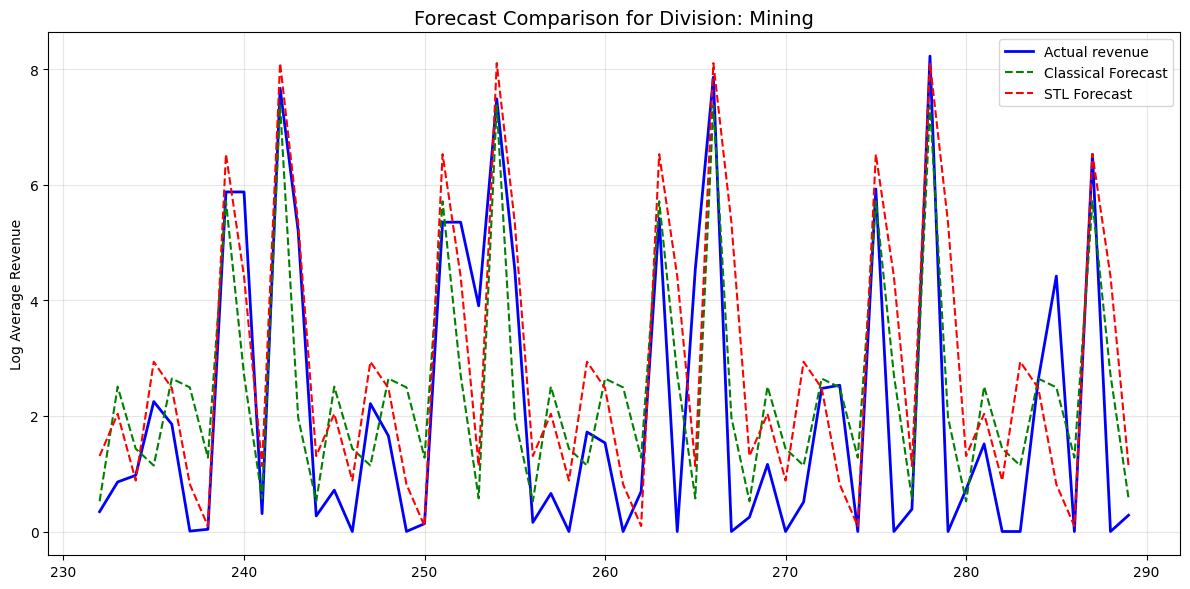

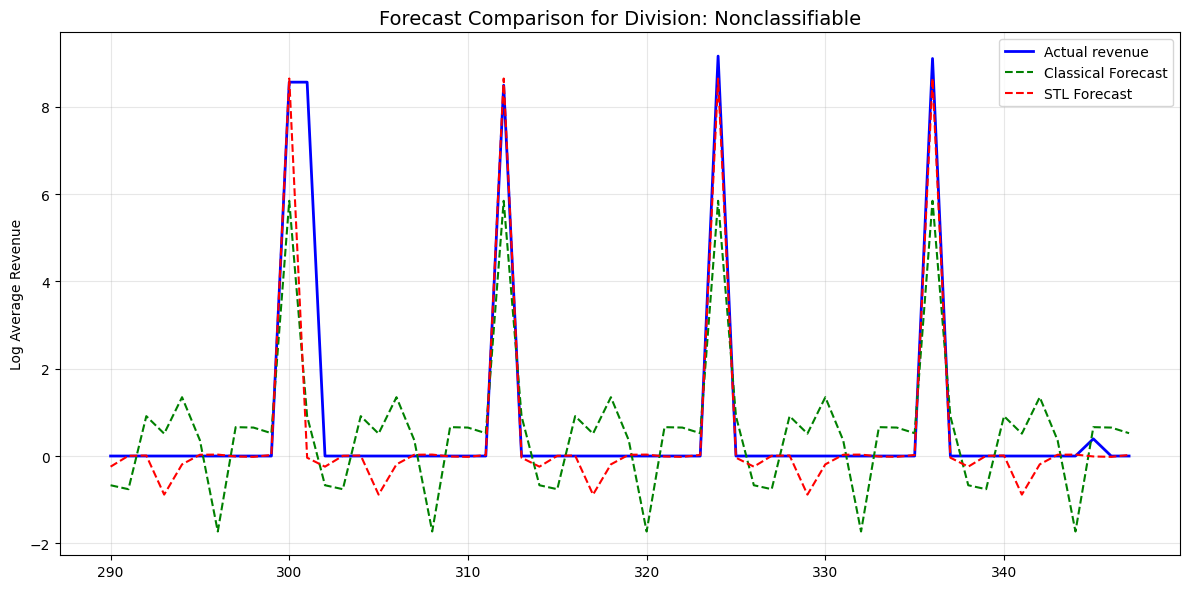

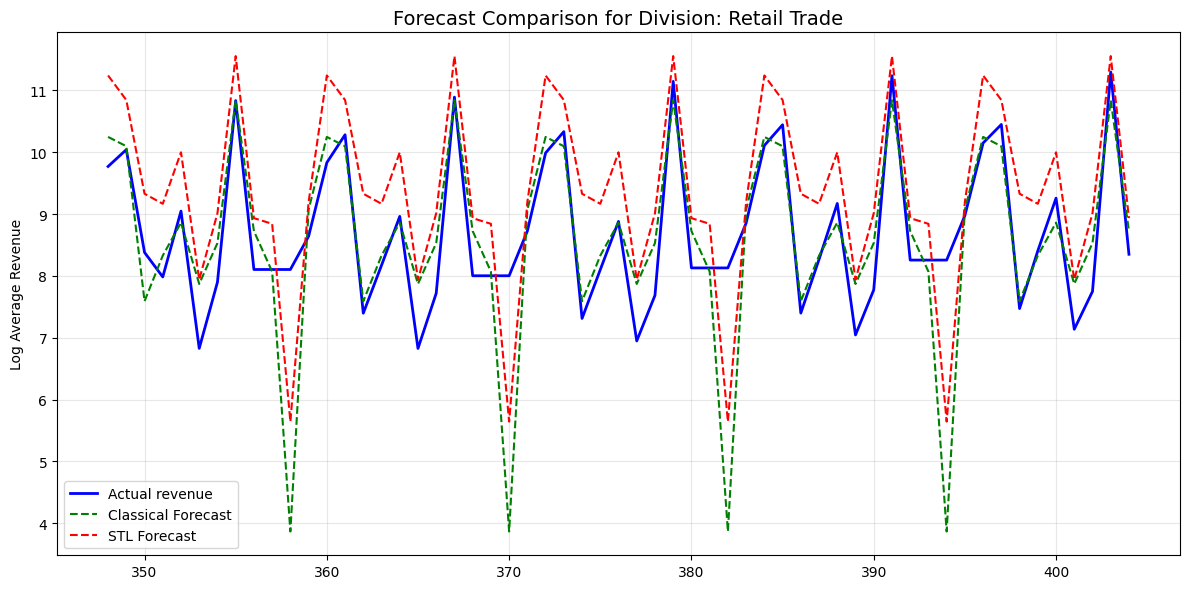

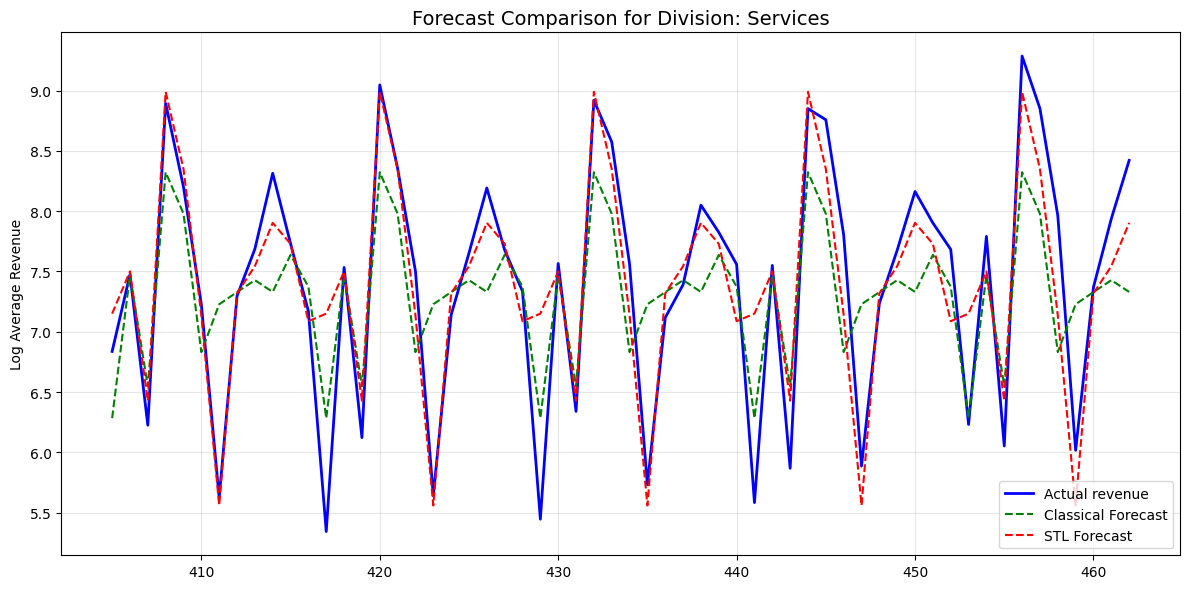

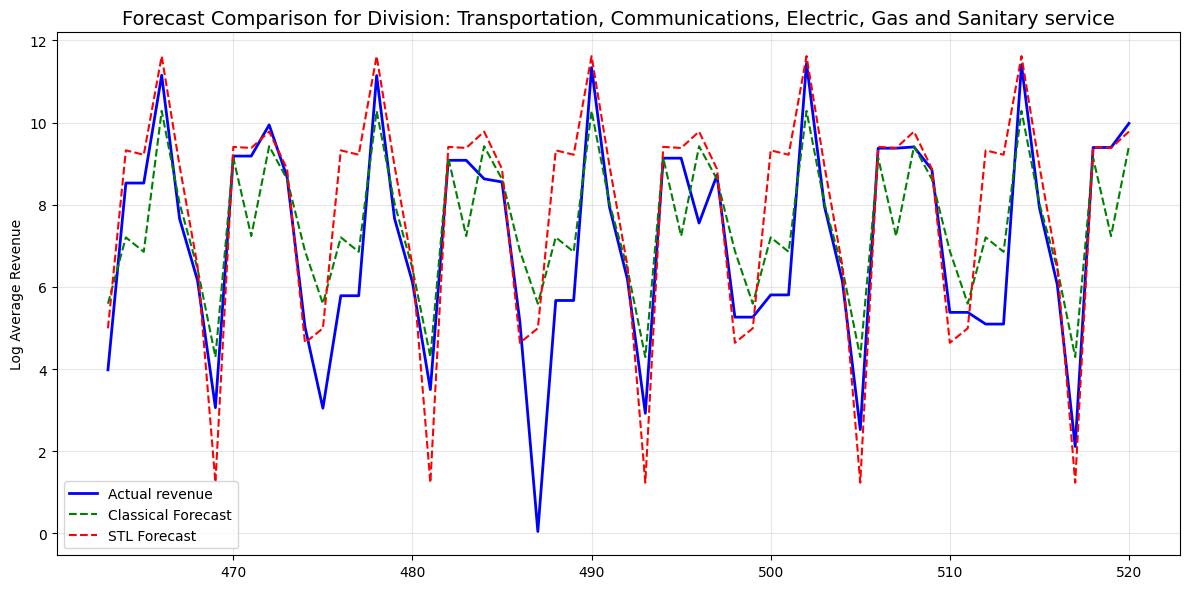

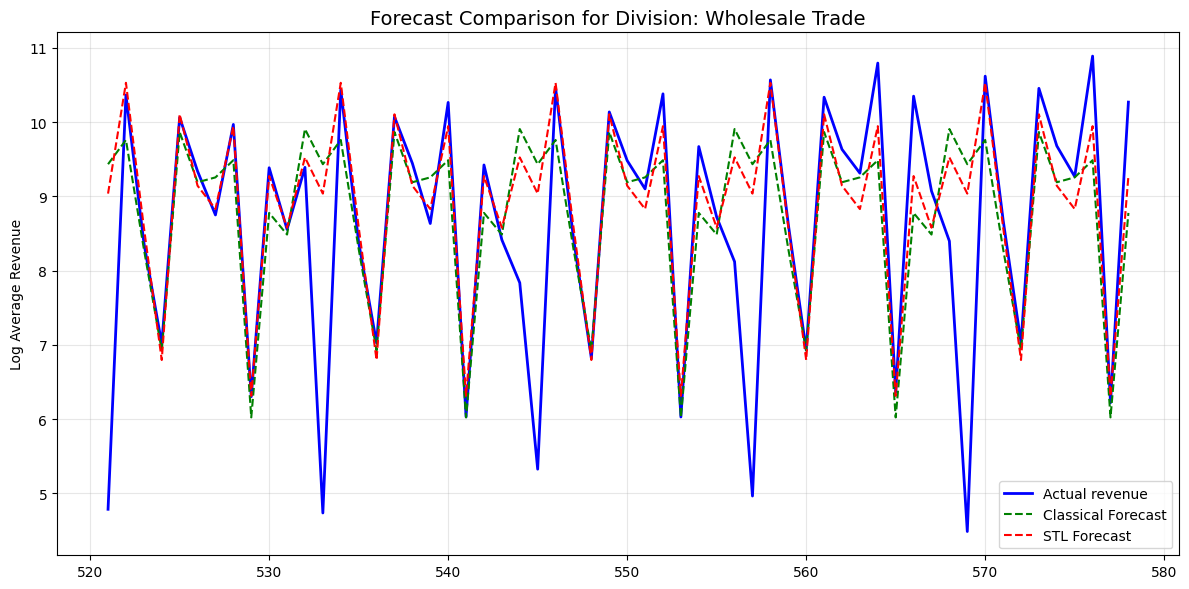

In [35]:
# Get unique divisions
divisions = test_data['division'].unique()
for division in divisions:
    division_test = test_data[test_data['division'] == division]
    
    plt.figure(figsize=(12, 6))
    plt.title(f'Forecast Comparison for Division: {division}', fontsize=14)
    
    # Plot all three series
    division_test['log_avg_revenue'].plot(label='Actual revenue', color='blue', linewidth=2)
    division_test['classical_naive_forecast'].plot(label='Classical Forecast', color='green', linestyle='--')
    division_test['stl_naive_forecast'].plot(label='STL Forecast', color='red', linestyle='--')
    
    plt.ylabel('Log Average Revenue')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [36]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Added missing imports

def evaluate_naive_forecasts(test_data, target_col='log_avg_revenue', group_col='division'):
    """
    Evaluates classical and STL naive forecasts on grouped test data, including Ljung-Box tests for residuals.
    
    Parameters:
        test_data (DataFrame): The test dataset containing actual values and both forecast types
        target_col (str): Name of the column containing true values
        group_col (str): Name of the column used to group data (e.g., 'division')
    
    Returns:
        tuple: (metrics_df, lb_results_df, predictions_dict)
            metrics_df - DataFrame of MSE, MAE, RMSE per group and method
            lb_results_df - DataFrame of Ljung-Box test results per group and method
            predictions_dict - Dictionary containing both forecast types per group
    """
    
    predictions = {
        'classical': {},
        'stl': {}
    }
    
    metrics = []
    lb_results = []
    groups = test_data[group_col].unique()
    
    for group in groups:
        group_data = test_data[test_data[group_col] == group]
        actual = group_data[target_col]
        
        # Store predictions
        predictions['classical'][group] = group_data['classical_naive_forecast']
        predictions['stl'][group] = group_data['stl_naive_forecast']
        
        # Calculate residuals
        classical_residuals = actual - group_data['classical_naive_forecast']
        stl_residuals = actual - group_data['stl_naive_forecast']
        
        # Calculate metrics for classical decomposition
        classical_metrics = {
            'division': group,
            'method': 'classical naive',
            'MSE': mean_squared_error(actual, group_data['classical_naive_forecast']),
            'MAE': mean_absolute_error(actual, group_data['classical_naive_forecast']),
            'RMSE': np.sqrt(mean_squared_error(actual, group_data['classical_naive_forecast']))
        }
        metrics.append(classical_metrics)
        
        # Calculate metrics for STL decomposition
        stl_metrics = {
            'division': group,
            'method': 'stl naive',
            'MSE': mean_squared_error(actual, group_data['stl_naive_forecast']),
            'MAE': mean_absolute_error(actual, group_data['stl_naive_forecast']),
            'RMSE': np.sqrt(mean_squared_error(actual, group_data['stl_naive_forecast']))
        }
        metrics.append(stl_metrics)
        
        # Ljung-Box tests (using lag=10)
        classical_lb = acorr_ljungbox(classical_residuals.dropna(), lags=[10], return_df=True)
        stl_lb = acorr_ljungbox(stl_residuals.dropna(), lags=[10], return_df=True)
        
        lb_results.append({
            'division': group,
            'method': 'classical naive',
            'lb_stat': classical_lb['lb_stat'].iloc[0],
            'lb_pvalue': classical_lb['lb_pvalue'].iloc[0]
        })
        
        lb_results.append({
            'division': group,
            'method': 'stl naive',
            'lb_stat': stl_lb['lb_stat'].iloc[0],
            'lb_pvalue': stl_lb['lb_pvalue'].iloc[0]
        })
    
    # Create metrics DataFrame
    naive_metrics_df = pd.DataFrame(metrics)
    naive_metrics_df = naive_metrics_df[['division', 'method', 'MSE', 'MAE', 'RMSE']]
    
    # Create Ljung-Box results DataFrame
    lb_results_df = pd.DataFrame(lb_results)
    lb_results_df['interpretation'] = lb_results_df['lb_pvalue'].apply(
        lambda p: "Residuals have autocorrelation (model may need improvement)" 
                  if p < 0.05 
                  else "Residuals are white noise (model adequate)"
    )
    
    return naive_metrics_df, lb_results_df, predictions

# Usage
naive_metrics_df, naive_lb_results, predictions = evaluate_naive_forecasts(test_data)

# Display results
print("📊 Naive Forecast Metrics:")
display(naive_metrics_df)

print("\n🔍 Ljung-Box Test Results for Naive Forecasts:")
display(naive_lb_results)

# Optional: Print summary statistics
print("\n📊 Summary Statistics:")
print(naive_metrics_df.groupby('method')[['MSE', 'MAE', 'RMSE']].mean())

print("\n📝 Ljung-Box Test Interpretation:")
print("- p-value < 0.05: Reject NULL (residuals have autocorrelation → model may be inadequate)")
print("- p-value ≥ 0.05: Fail to reject NULL (residuals are white noise → model is well-specified)")

📊 Naive Forecast Metrics:


division           method  \
0                   Agriculture, Forestry and Fishing  classical naive   
1                   Agriculture, Forestry and Fishing        stl naive   
2                                        Construction  classical naive   
3                                        Construction        stl naive   
4                  Finance, Insurance and Real estate  classical naive   
5                  Finance, Insurance and Real estate        stl naive   
6                                       Manufacturing  classical naive   
7                                       Manufacturing        stl naive   
8                                              Mining  classical naive   
9                                              Mining        stl naive   
10                                    Nonclassifiable  classical naive   
11                                    Nonclassifiable        stl naive   
12                                       Retail Trade  classical naive   
13                                       Retail Trade        stl naive   
14                                           Services  classical naive   
15                                           Services        stl naive   
16  Transportation, Communications, Electric, Gas ...  classical naive   
17  Transportation, Communications, Electric, Gas ...        stl naive   
18                                    Wholesale Trade  classical naive   
19                                    Wholesale Trade        stl naive   

         MSE       MAE      RMSE  
0   4.917690  1.855304  2.217586  
1   0.626893  0.700366  0.791766  
2   8.205610  1.958642  2.864544  
3   3.967296  1.610295  1.991807  
4   0.981511  0.836016  0.990712  
5   0.323755  0.425862  0.568994  
6   0.138564  0.298144  0.372242  
7   0.048338  0.169048  0.219860  
8   2.585096  1.258732  1.607823  
9   3.377589  1.271207  1.837822  
10  2.373608  1.078829  1.540652  
11  1.363474  0.303000  1.167679  
12  1.479671  0.646974  1.216417  
13  1.393129  1.035422  1.180309  
14  0.461563  0.531083  0.679384  
15  0.246131  0.319491  0.496116  
16  2.002484  1.055407  1.415092  
17  2.922100  1.124048  1.709415  
18  2.279496  0.869188  1.509800  
19  1.728442  0.656536  1.314702


🔍 Ljung-Box Test Results for Naive Forecasts:


division           method  \
0                   Agriculture, Forestry and Fishing  classical naive   
1                   Agriculture, Forestry and Fishing        stl naive   
2                                        Construction  classical naive   
3                                        Construction        stl naive   
4                  Finance, Insurance and Real estate  classical naive   
5                  Finance, Insurance and Real estate        stl naive   
6                                       Manufacturing  classical naive   
7                                       Manufacturing        stl naive   
8                                              Mining  classical naive   
9                                              Mining        stl naive   
10                                    Nonclassifiable  classical naive   
11                                    Nonclassifiable        stl naive   
12                                       Retail Trade  classical naive   
13                                       Retail Trade        stl naive   
14                                           Services  classical naive   
15                                           Services        stl naive   
16  Transportation, Communications, Electric, Gas ...  classical naive   
17  Transportation, Communications, Electric, Gas ...        stl naive   
18                                    Wholesale Trade  classical naive   
19                                    Wholesale Trade        stl naive   

      lb_stat     lb_pvalue                                     interpretation  
0   38.271123  3.404062e-05  Residuals have autocorrelation (model may need...  
1   19.752428  3.168319e-02  Residuals have autocorrelation (model may need...  
2   36.578211  6.693157e-05  Residuals have autocorrelation (model may need...  
3   15.641323  1.103706e-01         Residuals are white noise (model adequate)  
4   29.454285  1.051512e-03  Residuals have autocorrelation (model may need...  
5   47.169214  8.796489e-07  Residuals have autocorrelation (model may need...  
6   33.295043  2.429649e-04  Residuals have autocorrelation (model may need...  
7   68.196325  9.873593e-11  Residuals have autocorrelation (model may need...  
8    6.066492  8.096463e-01         Residuals are white noise (model adequate)  
9   12.243051  2.691193e-01         Residuals are white noise (model adequate)  
10   5.822190  8.299742e-01         Residuals are white noise (model adequate)  
11   1.661524  9.983379e-01         Residuals are white noise (model adequate)  
12  19.242328  3.729054e-02  Residuals have autocorrelation (model may need...  
13  22.453778  1.295261e-02  Residuals have autocorrelation (model may need...  
14  63.057403  9.520814e-10  Residuals have autocorrelation (model may need...  
15   5.933440  8.208240e-01         Residuals are white noise (model adequate)  
16  18.899908  4.155257e-02  Residuals have autocorrelation (model may need...  
17  26.981035  2.622392e-03  Residuals have autocorrelation (model may need...  
18  11.591652  3.133146e-01         Residuals are white noise (model adequate)  
19  13.348645  2.048266e-01         Residuals are white noise (model adequate)


📊 Summary Statistics:
                      MSE       MAE      RMSE
method                                       
classical naive  2.542529  1.038832  1.441425
stl naive        1.599715  0.761527  1.127847

📝 Ljung-Box Test Interpretation:
- p-value < 0.05: Reject NULL (residuals have autocorrelation → model may be inadequate)
- p-value ≥ 0.05: Fail to reject NULL (residuals are white noise → model is well-specified)


In [67]:
train_data.head()

division year_month  avg_monthly_revenue  \
0  Agriculture, Forestry and Fishing 2000-01-01                3.096   
1  Agriculture, Forestry and Fishing 2000-02-01                3.096   
2  Agriculture, Forestry and Fishing 2000-03-01                3.096   
3  Agriculture, Forestry and Fishing 2000-04-01                3.096   
4  Agriculture, Forestry and Fishing 2000-05-01              288.055   

   log_avg_revenue  seasonal  trend  residual  log_avg_revenue_final_diff  
0         1.130111  1.167658    NaN       NaN                     0.00000  
1         1.130111  1.168158    NaN       NaN                     0.00000  
2         1.130111 -2.072560    NaN       NaN                     0.00000  
3         1.130111 -2.080703    NaN       NaN                     0.00000  
4         5.663151  1.911579    NaN       NaN                     4.53304

Fit: manual arima, auto arima, auto sarima

In [37]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox

def fit_evaluate_models(train_data, test_data):
    """
    Fits and evaluates three types of ARIMA models for each division and returns consolidated metrics.
    
    Returns:
        pd.DataFrame: Consolidated metrics in long format with columns:
                      division, method, MSE, MAE, RMSE
        pd.DataFrame: Ljung-Box test results for each model
    """
    # 1. Manual ARIMA models configuration
    manual_arima_orders = {
        "Agriculture, Forestry and Fishing": ((0,0,2), (0,1,0,12)),
        "Construction": ((0,0,2), (0,1,0,12)),
        "Finance, Insurance and Real estate": ((0,0,1), None),
        "Manufacturing": ((0,0,1), None),
        "Mining": ((0,0,1), (0,1,0,12)),
        "Nonclassifiable": ((0,0,1), (0,1,0,12)),
        "Retail Trade": ((0,0,1), (0,1,0,12)),
        "Services": ((0,0,3), None),
        "Transportation, Communications, Electric, Gas and Sanitary service": ((0,0,1), None),
        "Wholesale Trade": ((0,0,1), None)
    }

    # Store all metrics in a list
    all_metrics = []
    lb_test_results = []

    # 1. Manual ARIMA
    print("="*50)
    print("Fitting Manual ARIMA Models")
    print("="*50)
    for division, group_data in train_data.groupby('division'):
        series = group_data['log_avg_revenue_final_diff']
        arima_order, seasonal_order = manual_arima_orders.get(division, ((0,0,0), None))
        
        model = ARIMA(series, order=arima_order, seasonal_order=seasonal_order) if seasonal_order \
                else ARIMA(series, order=arima_order)
        
        fitted_model = model.fit()
        
        # Evaluate
        test_series = test_data[test_data['division'] == division]['log_avg_revenue_final_diff']
        forecast = fitted_model.forecast(steps=len(test_series))
        
        mse = mean_squared_error(test_series, forecast)
        mae = mean_absolute_error(test_series, forecast)
        rmse = np.sqrt(mse)
        
        all_metrics.append({
            'division': division,
            'method': 'manual',
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse
        })
        
        # Ljung-Box test on residuals
        residuals = fitted_model.resid.dropna()
        lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
        lb_test_results.append({
            'division': division,
            'method': 'manual',
            'lb_stat': lb_test['lb_stat'].iloc[0],
            'lb_pvalue': lb_test['lb_pvalue'].iloc[0]
        })

    # 2. Auto ARIMA (non-seasonal)
    print("\n" + "="*50)
    print("Fitting Auto ARIMA Models")
    print("="*50)
    for division, group_data in train_data.groupby('division'):
        series = group_data['log_avg_revenue']
        
        model = auto_arima(
            series,
            seasonal=False,
            trace=True,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )
        
        # Evaluate
        test_series = test_data[test_data['division'] == division]['log_avg_revenue']
        forecast, _ = model.predict(n_periods=len(test_series), return_conf_int=True)
        
        mse = mean_squared_error(test_series, forecast)
        mae = mean_absolute_error(test_series, forecast)
        rmse = np.sqrt(mse)
        
        all_metrics.append({
            'division': division,
            'method': 'auto arima',
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse
        })
        
        # Ljung-Box test on residuals
        residuals = model.resid()
        lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
        lb_test_results.append({
            'division': division,
            'method': 'auto arima',
            'lb_stat': lb_test['lb_stat'].iloc[0],
            'lb_pvalue': lb_test['lb_pvalue'].iloc[0]
        })

    # 3. Auto SARIMA (seasonal)
    print("\n" + "="*50)
    print("Fitting Auto SARIMA Models")
    print("="*50)
    for division, group_data in train_data.groupby('division'):
        series = group_data['log_avg_revenue']
        
        model = auto_arima(
            series,
            seasonal=True,
            m=12,
            trace=True,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )
        
        # Evaluate
        test_series = test_data[test_data['division'] == division]['log_avg_revenue']
        forecast, _ = model.predict(n_periods=len(test_series), return_conf_int=True)
        
        mse = mean_squared_error(test_series, forecast)
        mae = mean_absolute_error(test_series, forecast)
        rmse = np.sqrt(mse)
        
        all_metrics.append({
            'division': division,
            'method': 'auto sarima',
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse
        })
        
        # Ljung-Box test on residuals
        residuals = model.resid()
        lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
        lb_test_results.append({
            'division': division,
            'method': 'auto sarima',
            'lb_stat': lb_test['lb_stat'].iloc[0],
            'lb_pvalue': lb_test['lb_pvalue'].iloc[0]
        })

    # Convert to DataFrames and sort
    metrics_df = pd.DataFrame(all_metrics)
    metrics_df = metrics_df.sort_values(['division', 'method']).reset_index(drop=True)
    
    lb_df = pd.DataFrame(lb_test_results)
    lb_df = lb_df.sort_values(['division', 'method']).reset_index(drop=True)
    
    return metrics_df, lb_df

# Run the complete analysis
final_metrics, lb_results = fit_evaluate_models(train_data, test_data)

# Display the final consolidated metrics
print("\nFinal Consolidated Metrics:")
display(final_metrics)

print("\nLjung-Box Test Results (lag=10):")
display(lb_results)

Fitting Manual ARIMA Models


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/


Fitting Auto ARIMA Models
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1020.967, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1142.312, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1128.986, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1043.330, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1140.334, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1023.393, Time=0.06 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1023.348, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1017.133, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1015.948, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1019.040, Time=0.05 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=995.320, Time=0.23 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1020.404, Time=0.08 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1001.318, Time=0.27 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=1018.917, Time=0.30 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1021.572, Time=0.11 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=1004.997, Time=0.31 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best model:  ARIMA(1,1,4)(0,0,0)[0] intercept
Total fit time: 2.256 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho

 ARIMA(2,0,2)(0,0,0)[0]             : AIC=954.117, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1535.971, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1008.915, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1348.655, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho

 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=953.983, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1201.825, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=982.572, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=922.226, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=925.189, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=920.381, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=943.818, Time=0.01 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=922.100, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=894.197, Time=0.11 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=909.531, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=882.350, Time=0.17 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=885.052, Time=0.13 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=886.068, Time=0.18 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=886.711, Time=0.17 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=885.678, Time=0.12 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 2.192 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1450.779, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1075.449, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1299.205, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1045.255, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1040.181, Time=0.02 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 

 ARIMA(4,0,0)(0,0,0)[0]             : AIC=1036.516, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=1035.806, Time=0.04 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=977.453, Time=0.13 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[0]             : AIC=996.918, Time=0.13 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=986.196, Time=0.20 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0]             : AIC=983.482, Time=0.15 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=906.710, Time=0.21 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=966.169, Time=0.14 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=961.369, Time=0.09 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=921.797, Time=0.23 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=968.493, Time=0.04 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=968.018, Time=0.19 sec

Best model:  ARIMA(5,0,1)(0,0,0)[0] intercept
Total fit time: 1.776 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=553.361, Time=0.03 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=515.134, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=551.383, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=457.886, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=456.145, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=449.364, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=450.605, Time=0.04 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho

 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=447.626, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=454.324, Time=0.02 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=448.837, Time=0.03 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=414.479, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=416.194, Time=0.05 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho

 ARIMA(5,1,1)(0,0,0)[0]             : AIC=416.040, Time=0.07 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=408.473, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=406.944, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=405.783, Time=0.04 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=408.997, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=418.793, Time=0.04 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=367.116, Time=0.14 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=406.729, Time=0.06 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=390.631, Time=0.19 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[0]             : AIC=368.272, Time=0.14 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=407.496, Time=0.08 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[0]             : AIC=inf, Time=0.24 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 2.583 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1259.972, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1193.688, Time=0.01 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1257.972, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1071.238, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1065.229, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1062.907, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1064.552, Time=0.05 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho

 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1060.929, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1063.248, Time=0.02 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1062.574, Time=0.03 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1026.831, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1025.373, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1058.836, Time=0.02 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1026.998, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1069.249, Time=0.01 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1028.570, Time=0.04 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1028.315, Time=0.12 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 1.473 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/P

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1235.893, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1172.657, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1233.901, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1141.309, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1140.005, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1111.425, Time=0.04 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho

 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1095.939, Time=0.05 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1093.978, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1109.445, Time=0.02 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1056.206, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1054.421, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1072.588, Time=0.03 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1056.185, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1138.012, Time=0.01 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1071.978, Time=0.06 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1058.122, Time=0.09 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 1.188 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/P

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1087.886, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1061.785, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1085.886, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1049.492, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=981.445, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=964.263, Time=0.03 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho

 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=949.375, Time=0.05 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=947.420, Time=0.02 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,0)[0]             : AIC=962.283, Time=0.02 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=877.308, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=882.780, Time=0.06 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[0]             : AIC=863.035, Time=0.18 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=869.002, Time=0.15 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,0)[0]             : AIC=805.573, Time=0.21 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=876.708, Time=0.11 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,4)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=847.911, Time=0.19 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec

Best model:  ARIMA(5,1,3)(0,0,0)[0]          
Total fit time: 2.372 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=439.745, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=620.033, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=552.723, Time=0.02 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=618.043, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=435.292, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=535.956, Time=0.02 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=419.841, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=521.925, Time=0.03 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=395.042, Time=0.20 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=469.252, Time=0.20 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=396.858, Time=0.24 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=396.748, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=453.042, Time=0.05 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=398.604, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=408.529, Time=0.04 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0] intercept
Total fit time: 2.237 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1562.843, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1123.078, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1402.431, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1089.264, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1089.267, Time=0.02 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 

 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=977.593, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=980.937, Time=0.02 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho

 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=920.734, Time=0.10 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=913.500, Time=0.12 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=908.717, Time=0.17 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=855.788, Time=0.24 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=914.283, Time=0.17 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=858.934, Time=0.25 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=897.051, Time=0.18 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[0]             : AIC=915.792, Time=0.14 sec

Best model:  ARIMA(5,0,1)(0,0,0)[0] intercept
Total fit time: 1.848 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=754.194, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=923.019, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=861.571, Time=0.01 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=921.021, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=751.957, Time=0.06 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=753.478, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=851.829, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=726.236, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=846.837, Time=0.02 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=638.033, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=745.602, Time=0.05 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=636.774, Time=0.17 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=692.093, Time=0.06 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=636.096, Time=0.26 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=637.512, Time=0.17 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=599.445, Time=0.28 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=567.049, Time=0.31 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=560.811, Time=0.28 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,0,0)[0]             : AIC=565.713, Time=0.25 sec

Best model:  ARIMA(4,1,4)(0,0,0)[0] intercept
Total fit time: 4.365 seconds

Fitting Auto SARIMA Models
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 

 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=750.000, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1142.312, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=815.412, Time=0.08 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=900.921, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1140.334, Time=0.01 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=871.986, Time=0.32 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.47 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=751.988, Time=1.58 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=751.836, Time=1.56 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1020.967, Time=0.06 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=1.28 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=750.110, Time=1.47 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=753.241, Time=2.27 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.69 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.45 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.67 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,0,1)[12] intercept   : AIC=inf, Time=0.71 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.51 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(1,0,1)[12] intercept   : AIC=inf, Time=0.68 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.50 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(1,0,1)[12] intercept   : AIC=inf, Time=0.83 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,1)[12]             : AIC=inf, Time=0.39 sec

Best model:  ARIMA(2,1,2)(1,0,1)[12] intercept
Total fit time: 15.249 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho

 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=675.224, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=943.818, Time=0.01 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=657.460, Time=0.36 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=783.219, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1535.971, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=920.381, Time=0.02 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.97 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=659.846, Time=0.42 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=780.946, Time=0.09 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=685.731, Time=0.16 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=648.928, Time=0.39 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=922.100, Time=0.04 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.17 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=654.582, Time=0.53 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=782.784, Time=0.10 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.33 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,0)[12] intercept   : AIC=645.403, Time=0.63 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=919.961, Time=0.06 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.44 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,1)[12] intercept   : AIC=654.416, Time=0.54 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,1)[12] intercept   : AIC=780.881, Time=0.22 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.71 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(1,0,0)[12] intercept   : AIC=647.350, Time=0.50 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,0)[12] intercept   : AIC=651.525, Time=0.54 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=661.018, Time=0.46 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(1,0,0)[12] intercept   : AIC=648.927, Time=0.57 sec
 ARIMA(3,0,0)(1,0,0)[12]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(3,0,0)(1,0,0)[12] intercept
Total fit time: 14.127 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 

 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=576.934, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=978.517, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.20 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=788.286, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1450.779, Time=0.01 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=763.020, Time=0.47 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=575.346, Time=0.46 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.15 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=inf, Time=1.62 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=2.38 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=575.716, Time=0.44 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=575.862, Time=0.27 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.69 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(1,0,0)[12] intercept   : AIC=578.525, Time=0.57 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=573.902, Time=0.20 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=972.753, Time=0.04 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=573.535, Time=0.97 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=1.56 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=573.860, Time=0.44 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=571.574, Time=0.49 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=571.876, Time=0.17 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=0.88 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=571.857, Time=0.24 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.53 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(2,0,0)[12] intercept   : AIC=573.478, Time=0.64 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.69 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=575.530, Time=1.25 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,0,0)[12]             : AIC=603.732, Time=0.26 sec

Best model:  ARIMA(0,0,1)(2,0,0)[12] intercept
Total fit time: 16.432 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 

 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-186.091, Time=1.01 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-186.499, Time=0.03 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-185.948, Time=0.19 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-185.384, Time=0.17 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-149.517, Time=0.01 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=-185.203, Time=0.09 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-185.233, Time=0.10 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=-183.238, Time=0.31 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-187.384, Time=0.04 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-185.959, Time=0.15 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=-183.959, Time=0.59 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=-189.508, Time=0.11 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=-188.175, Time=0.23 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=-188.164, Time=0.21 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=-186.175, Time=0.69 sec
 ARIMA(3,0,0)(0,1,0)[12] intercept   : AIC=-190.422, Time=0.12 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,1,0)[12] intercept   : AIC=-189.163, Time=0.41 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,1,1)[12] intercept   : AIC=-189.152, Time=0.34 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,1,1)[12] intercept   : AIC=-187.164, Time=0.84 sec
 ARIMA(4,0,0)(0,1,0)[12] intercept   : AIC=-188.429, Time=0.12 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,1,0)[12] intercept   : AIC=-189.455, Time=0.34 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=-192.304, Time=0.22 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,1,0)[12] intercept   : AIC=-190.763, Time=0.99 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=-190.751, Time=0.57 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=-188.600, Time=0.96 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-193.733, Time=0.20 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=-192.103, Time=0.48 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-192.096, Time=0.49 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=-189.865, Time=0.72 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-186.781, Time=0.05 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-192.308, Time=0.28 sec
 ARIMA(0,0,2)(0,1,0)[12] intercept   : AIC=-188.353, Time=0.16 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-190.294, Time=0.34 sec
 ARIMA(1,0,1)(0,1,0)[12]             : AIC=-189.262, Time=0.09 sec

Best model:  ARIMA(1,0,1)(0,1,0)[12] intercept
Total fit time: 11.647 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 

 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1259.972, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.11 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1257.972, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1083.050, Time=0.12 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=831.533, Time=0.13 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=827.846, Time=0.63 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.27 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.95 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=833.353, Time=0.44 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=771.783, Time=0.60 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=769.845, Time=0.15 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1008.354, Time=0.17 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=771.665, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1193.688, Time=0.01 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=882.306, Time=0.36 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.34 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=773.629, Time=0.79 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=749.597, Time=0.14 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=926.867, Time=0.22 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.13 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=751.594, Time=0.41 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,2)[12] intercept   : AIC=751.597, Time=0.48 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=1071.238, Time=0.02 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,2)[12] intercept   : AIC=820.765, Time=0.43 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.34 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,2)[12] intercept   : AIC=748.974, Time=1.16 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.77 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.61 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.46 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.70 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,2)[12]             : AIC=746.976, Time=1.05 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,2)[12]             : AIC=749.600, Time=0.35 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,1)[12]             : AIC=749.597, Time=0.24 sec
 ARIMA(2,1,0)(1,0,1)[12]             : AIC=747.600, Time=0.09 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,2)[12]             : AIC=771.631, Time=0.56 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,0,2)[12]             : AIC=inf, Time=1.72 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,2)[12]             : AIC=inf, Time=2.10 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,2)[12]             : AIC=inf, Time=1.18 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,0,2)[12]             : AIC=inf, Time=1.58 sec

Best model:  ARIMA(2,1,0)(2,0,2)[12]          
Total fit time: 26.172 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 

 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1235.893, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.09 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1233.901, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=912.838, Time=0.07 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=914.828, Time=0.21 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=914.827, Time=0.10 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1075.742, Time=0.05 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=916.723, Time=0.49 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.27 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=910.838, Time=0.02 sec
 ARIMA(0,1,0)(2,0,0)[12]             : AIC=912.828, Time=0.08 sec
 ARIMA(0,1,0)(1,0,1)[12]             : AIC=912.828, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=1073.747, Time=0.04 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho

 ARIMA(0,1,0)(2,0,1)[12]             : AIC=914.723, Time=0.31 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=725.018, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=1071.772, Time=0.02 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,0)[12]             : AIC=726.983, Time=0.29 sec
 ARIMA(0,1,1)(1,0,1)[12]             : AIC=726.982, Time=0.14 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12]             : AIC=906.948, Time=0.08 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,1)[12]             : AIC=728.981, Time=0.31 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=720.396, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=1072.083, Time=0.02 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,0)[12]             : AIC=722.338, Time=0.35 sec
 ARIMA(1,1,1)(1,0,1)[12]             : AIC=722.339, Time=0.17 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[12]             : AIC=906.640, Time=0.09 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,1)[12]             : AIC=inf, Time=1.42 sec
 ARIMA(2,1,1)(1,0,0)[12]             : AIC=722.361, Time=0.15 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,0)[12]             : AIC=722.358, Time=0.23 sec
 ARIMA(0,1,2)(1,0,0)[12]             : AIC=720.398, Time=0.09 sec
 ARIMA(2,1,0)(1,0,0)[12]             : AIC=inf, Time=0.06 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[12]             : AIC=721.351, Time=0.55 sec

Best model:  ARIMA(1,1,1)(1,0,0)[12]          
Total fit time: 7.129 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 

 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1087.886, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.11 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1085.886, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=729.996, Time=0.06 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=716.383, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=929.417, Time=0.05 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=714.655, Time=0.35 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=711.074, Time=0.73 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=713.599, Time=0.43 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=634.444, Time=0.98 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=637.661, Time=0.55 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=638.852, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=638.944, Time=0.18 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,2)[12] intercept   : AIC=615.176, Time=1.54 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,2)[12] intercept   : AIC=618.160, Time=0.58 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=619.105, Time=0.54 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=618.625, Time=0.20 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.79 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.83 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=2.77 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,0,2)[12] intercept   : AIC=571.123, Time=1.96 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,2)[12] intercept   : AIC=568.695, Time=1.51 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,2)[12] intercept   : AIC=inf, Time=1.37 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,1)[12] intercept   : AIC=569.581, Time=0.51 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.42 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=1.60 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.51 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,2)[12] intercept   : AIC=603.708, Time=0.72 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(1,0,2)[12] intercept   : AIC=571.485, Time=3.35 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=2.16 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=2.22 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,2)[12] intercept   : AIC=596.828, Time=0.90 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=2.02 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,2)[12]             : AIC=567.351, Time=0.85 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,2)[12]             : AIC=681.878, Time=0.68 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,1)[12]             : AIC=567.968, Time=0.29 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,0,2)[12]             : AIC=inf, Time=2.01 sec
 ARIMA(3,1,1)(0,0,1)[12]             : AIC=747.695, Time=0.17 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,0,1)[12]             : AIC=568.496, Time=0.79 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,2)[12]             : AIC=566.034, Time=0.97 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,2)[12]             : AIC=690.764, Time=0.52 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,1)[12]             : AIC=566.548, Time=0.24 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,2)[12]             : AIC=561.003, Time=1.72 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,1)[12]             : AIC=567.111, Time=1.51 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,2)[12]             : AIC=559.435, Time=1.89 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,2)[12]             : AIC=564.250, Time=0.80 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,1)[12]             : AIC=565.317, Time=0.64 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12]             : AIC=564.753, Time=0.21 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,2)[12]             : AIC=557.363, Time=0.97 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,2)[12]             : AIC=562.258, Time=0.59 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,1)[12]             : AIC=563.324, Time=0.45 sec
 ARIMA(0,1,1)(1,0,1)[12]             : AIC=562.753, Time=0.16 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,2)[12]             : AIC=709.074, Time=0.84 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,0,2)[12]             : AIC=559.333, Time=2.17 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,2)[12]             : AIC=632.501, Time=0.88 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,2)[12]             : AIC=560.367, Time=1.93 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.54 sec

Best model:  ARIMA(0,1,1)(2,0,2)[12]          
Total fit time: 58.074 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 

 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-118.047, Time=1.26 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-116.048, Time=0.03 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-114.553, Time=0.25 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-114.270, Time=0.16 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-75.564, Time=0.01 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-119.736, Time=0.99 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-120.157, Time=0.29 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=-119.861, Time=0.54 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-119.036, Time=0.13 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=-117.334, Time=0.17 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,1,0)[12] intercept   : AIC=-118.121, Time=0.37 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,1,0)[12] intercept   : AIC=-118.423, Time=0.37 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-114.263, Time=0.25 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,1,0)[12] intercept   : AIC=-119.085, Time=0.23 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,1,0)[12] intercept   : AIC=-116.886, Time=0.25 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,1,0)[12] intercept   : AIC=-117.102, Time=0.39 sec
 ARIMA(2,0,2)(0,1,0)[12]             : AIC=-109.461, Time=0.20 sec

Best model:  ARIMA(2,0,2)(0,1,0)[12] intercept
Total fit time: 5.897 seconds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=440.912, Time=1.54 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=432.380, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=433.351, Time=0.11 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=433.315, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=432.348, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=432.995, Time=0.07 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=433.010, Time=0.10 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=434.994, Time=0.19 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=432.602, Time=0.07 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=432.563, Time=0.05 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=434.525, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12]          
Total fit time: 2.445 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 

 ARIMA(2,1,2)(1,1,1)[12]             : AIC=151.541, Time=1.27 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=325.064, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=243.983, Time=0.06 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=152.451, Time=0.43 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,1,1)[12]             : AIC=149.875, Time=0.85 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,1,0)[12]             : AIC=150.720, Time=0.31 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,1,2)[12]             : AIC=151.000, Time=1.17 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,1,0)[12]             : AIC=150.593, Time=1.01 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,1,2)[12]             : AIC=152.755, Time=1.57 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,1)[12]             : AIC=147.876, Time=0.34 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=148.728, Time=0.14 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,1,1)[12]             : AIC=149.541, Time=0.60 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,2)[12]             : AIC=149.006, Time=0.82 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,1,0)[12]             : AIC=148.594, Time=0.45 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,1,2)[12]             : AIC=150.760, Time=1.35 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,1)[12]             : AIC=146.337, Time=0.25 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=146.846, Time=0.11 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,1,1)[12]             : AIC=148.042, Time=0.40 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,2)[12]             : AIC=147.561, Time=0.60 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,1,0)[12]             : AIC=146.903, Time=0.21 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,1,2)[12]             : AIC=149.371, Time=0.84 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,1,1)[12]             : AIC=147.925, Time=0.64 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=147.292, Time=0.28 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,1,1)[12]             : AIC=150.053, Time=0.46 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,1)[12] intercept   : AIC=148.115, Time=0.74 sec

Best model:  ARIMA(0,1,2)(0,1,1)[12]          
Total fit time: 14.924 seconds

Final Consolidated Metrics:


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 

division       method       MSE  \
0                   Agriculture, Forestry and Fishing   auto arima  7.035047   
1                   Agriculture, Forestry and Fishing  auto sarima  0.871657   
2                   Agriculture, Forestry and Fishing       manual  0.100965   
3                                        Construction   auto arima  6.768790   
4                                        Construction  auto sarima  1.765457   
5                                        Construction       manual  3.045024   
6                  Finance, Insurance and Real estate   auto arima  5.248812   
7                  Finance, Insurance and Real estate  auto sarima  0.793858   
8                  Finance, Insurance and Real estate       manual  0.236288   
9                                       Manufacturing   auto arima  0.482260   
10                                      Manufacturing  auto sarima  0.021172   
11                                      Manufacturing       manual  0.015105   
12                                             Mining   auto arima  6.496443   
13                                             Mining  auto sarima  6.876711   
14                                             Mining       manual  8.616072   
15                                    Nonclassifiable   auto arima  6.104631   
16                                    Nonclassifiable  auto sarima  1.735437   
17                                    Nonclassifiable       manual  2.505592   
18                                       Retail Trade   auto arima  2.036264   
19                                       Retail Trade  auto sarima  0.674713   
20                                       Retail Trade       manual  0.363233   
21                                           Services   auto arima  1.011773   
22                                           Services  auto sarima  0.235893   
23                                           Services       manual  0.122328   
24  Transportation, Communications, Electric, Gas ...   auto arima  4.925133   
25  Transportation, Communications, Electric, Gas ...  auto sarima  1.897855   
26  Transportation, Communications, Electric, Gas ...       manual  1.780813   
27                                    Wholesale Trade   auto arima  3.552624   
28                                    Wholesale Trade  auto sarima  1.771850   
29                                    Wholesale Trade       manual  0.762769   

         MAE      RMSE  
0   2.079858  2.652366  
1   0.665886  0.933626  
2   0.225601  0.317749  
3   1.925339  2.601690  
4   0.972293  1.328705  
5   0.697410  1.745000  
6   1.829764  2.291029  
7   0.710761  0.890987  
8   0.348967  0.486094  
9   0.600883  0.694450  
10  0.115232  0.145506  
11  0.085611  0.122904  
12  2.232250  2.548812  
13  1.982587  2.622348  
14  1.801923  2.935315  
15  1.472196  2.470755  
16  0.391479  1.317360  
17  0.360241  1.582906  
18  1.059717  1.426977  
19  0.496895  0.821409  
20  0.411175  0.602688  
21  0.759181  1.005869  
22  0.279340  0.485689  
23  0.207466  0.349754  
24  1.906995  2.219264  
25  0.867098  1.377627  
26  0.737878  1.334471  
27  1.416268  1.884840  
28  0.624515  1.331109  
29  0.383019  0.873367


Ljung-Box Test Results (lag=10):


division       method  \
0                   Agriculture, Forestry and Fishing   auto arima   
1                   Agriculture, Forestry and Fishing  auto sarima   
2                   Agriculture, Forestry and Fishing       manual   
3                                        Construction   auto arima   
4                                        Construction  auto sarima   
5                                        Construction       manual   
6                  Finance, Insurance and Real estate   auto arima   
7                  Finance, Insurance and Real estate  auto sarima   
8                  Finance, Insurance and Real estate       manual   
9                                       Manufacturing   auto arima   
10                                      Manufacturing  auto sarima   
11                                      Manufacturing       manual   
12                                             Mining   auto arima   
13                                             Mining  auto sarima   
14                                             Mining       manual   
15                                    Nonclassifiable   auto arima   
16                                    Nonclassifiable  auto sarima   
17                                    Nonclassifiable       manual   
18                                       Retail Trade   auto arima   
19                                       Retail Trade  auto sarima   
20                                       Retail Trade       manual   
21                                           Services   auto arima   
22                                           Services  auto sarima   
23                                           Services       manual   
24  Transportation, Communications, Electric, Gas ...   auto arima   
25  Transportation, Communications, Electric, Gas ...  auto sarima   
26  Transportation, Communications, Electric, Gas ...       manual   
27                                    Wholesale Trade   auto arima   
28                                    Wholesale Trade  auto sarima   
29                                    Wholesale Trade       manual   

       lb_stat      lb_pvalue  
0    28.714468   1.385755e-03  
1     3.165216   9.772641e-01  
2     5.043187   8.882745e-01  
3    50.109690   2.547924e-07  
4     3.476223   9.678996e-01  
5    12.426283   2.575392e-01  
6    16.959887   7.525630e-02  
7     4.376792   9.287527e-01  
8     3.240245   9.751915e-01  
9    19.839157   3.081123e-02  
10  795.906591  1.565212e-164  
11    3.989051   9.478395e-01  
12   36.007538   8.392538e-05  
13   43.143855   4.686970e-06  
14   49.453077   3.363917e-07  
15   14.349899   1.576215e-01  
16   11.663582   3.082024e-01  
17   33.453035   2.285141e-04  
18   38.188776   3.518453e-05  
19   10.666769   3.840621e-01  
20    1.598858   9.985931e-01  
21    7.944548   6.342535e-01  
22  784.839160  3.746031e-162  
23    9.674637   4.694871e-01  
24   48.348475   5.360357e-07  
25  568.989843  7.720402e-116  
26    4.081616   9.435900e-01  
27   12.882722   2.303031e-01  
28   31.340969   5.152718e-04  
29   11.905831   2.914083e-01

In [38]:
# After displaying lb_results, add interpretation
print("\nLjung-Box Test Interpretation:")
print("- p-value < 0.05: Reject NULL (residuals have autocorrelation → model may be inadequate)")
print("- p-value ≥ 0.05: Fail to reject NULL (residuals are white noise → model is well-specified)")

# Add a column for interpretation in the results table
lb_results['interpretation'] = lb_results['lb_pvalue'].apply(
    lambda p: "Residuals have autocorrelation (model may need improvement)" 
              if p < 0.05 
              else "Residuals are white noise (model adequate)"
)

print("\nLjung-Box Test Results with Interpretation:")
display(lb_results)


Ljung-Box Test Interpretation:
- p-value < 0.05: Reject NULL (residuals have autocorrelation → model may be inadequate)
- p-value ≥ 0.05: Fail to reject NULL (residuals are white noise → model is well-specified)

Ljung-Box Test Results with Interpretation:


division       method  \
0                   Agriculture, Forestry and Fishing   auto arima   
1                   Agriculture, Forestry and Fishing  auto sarima   
2                   Agriculture, Forestry and Fishing       manual   
3                                        Construction   auto arima   
4                                        Construction  auto sarima   
5                                        Construction       manual   
6                  Finance, Insurance and Real estate   auto arima   
7                  Finance, Insurance and Real estate  auto sarima   
8                  Finance, Insurance and Real estate       manual   
9                                       Manufacturing   auto arima   
10                                      Manufacturing  auto sarima   
11                                      Manufacturing       manual   
12                                             Mining   auto arima   
13                                             Mining  auto sarima   
14                                             Mining       manual   
15                                    Nonclassifiable   auto arima   
16                                    Nonclassifiable  auto sarima   
17                                    Nonclassifiable       manual   
18                                       Retail Trade   auto arima   
19                                       Retail Trade  auto sarima   
20                                       Retail Trade       manual   
21                                           Services   auto arima   
22                                           Services  auto sarima   
23                                           Services       manual   
24  Transportation, Communications, Electric, Gas ...   auto arima   
25  Transportation, Communications, Electric, Gas ...  auto sarima   
26  Transportation, Communications, Electric, Gas ...       manual   
27                                    Wholesale Trade   auto arima   
28                                    Wholesale Trade  auto sarima   
29                                    Wholesale Trade       manual   

       lb_stat      lb_pvalue  \
0    28.714468   1.385755e-03   
1     3.165216   9.772641e-01   
2     5.043187   8.882745e-01   
3    50.109690   2.547924e-07   
4     3.476223   9.678996e-01   
5    12.426283   2.575392e-01   
6    16.959887   7.525630e-02   
7     4.376792   9.287527e-01   
8     3.240245   9.751915e-01   
9    19.839157   3.081123e-02   
10  795.906591  1.565212e-164   
11    3.989051   9.478395e-01   
12   36.007538   8.392538e-05   
13   43.143855   4.686970e-06   
14   49.453077   3.363917e-07   
15   14.349899   1.576215e-01   
16   11.663582   3.082024e-01   
17   33.453035   2.285141e-04   
18   38.188776   3.518453e-05   
19   10.666769   3.840621e-01   
20    1.598858   9.985931e-01   
21    7.944548   6.342535e-01   
22  784.839160  3.746031e-162   
23    9.674637   4.694871e-01   
24   48.348475   5.360357e-07   
25  568.989843  7.720402e-116   
26    4.081616   9.435900e-01   
27   12.882722   2.303031e-01   
28   31.340969   5.152718e-04   
29   11.905831   2.914083e-01   

                                       interpretation  
0   Residuals have autocorrelation (model may need...  
1          Residuals are white noise (model adequate)  
2          Residuals are white noise (model adequate)  
3   Residuals have autocorrelation (model may need...  
4          Residuals are white noise (model adequate)  
5          Residuals are white noise (model adequate)  
6          Residuals are white noise (model adequate)  
7          Residuals are white noise (model adequate)  
8          Residuals are white noise (model adequate)  
9   Residuals have autocorrelation (model may need...  
10  Residuals have autocorrelation (model may need...  
11         Residuals are white noise (model adequate)  
12  Residuals have autocorrelation (model may need...  
13  Residuals have autocorrelation (model may need...  
14  Residu

Comparing metrics: manual picking of model, auto arima, auto sarima, classical naive and stl naive

In [39]:
# 1. First, merge all metrics DataFrames
combined_metrics = pd.concat([final_metrics, naive_metrics_df], ignore_index=True)

# 2. Merge with Ljung-Box results (both ARIMA and naive)
all_lb_results = pd.concat([lb_results, naive_lb_results], ignore_index=True)
lb_interpretations = all_lb_results[['division', 'method', 'interpretation']]

# 3. Combine metrics with Ljung-Box interpretations
combined_with_lb = pd.merge(
    combined_metrics,
    lb_interpretations,
    on=['division', 'method'],
    how='left'
)

# 4. Rank models within each division by MSE (ascending)
combined_with_lb['rank'] = combined_with_lb.groupby('division')['MSE'].rank(ascending=True)

# 5. Sort by division and then by rank
combined_sorted = combined_with_lb.sort_values(['division', 'rank']).drop(columns=['rank'])

# 6. Add a ranking indicator column
combined_sorted['ranking'] = combined_sorted.groupby('division').cumcount() + 1
combined_sorted['ranking'] = combined_sorted['ranking'].map({
    1: '1st (best)', 
    2: '2nd', 
    3: '3rd',
    4: '4th',
    5: '5th (worst)'
})

# 7. Create a model quality column combining MSE rank and residual diagnostics
def get_quality_assessment(row):
    if row['ranking'] == '1st (best)' and "white noise" in row['interpretation']:
        return "✅ Best performer with clean residuals"
    elif "white noise" in row['interpretation']:
        return f"☑️ Rank {row['ranking'][0]} with clean residuals"
    elif row['ranking'] == '1st (best)':
        return "⚠️ Best performer but with residual autocorrelation"
    else:
        return f"⛔ Rank {row['ranking'][0]} with residual issues"

combined_sorted['quality_assessment'] = combined_sorted.apply(get_quality_assessment, axis=1)

# 8. Reorder columns for better presentation
column_order = [
    'division', 
    'ranking',
    'quality_assessment',
    'method', 
    'MSE', 
    'MAE', 
    'RMSE',
    'interpretation'
]
combined_sorted = combined_sorted[column_order]

# 9. Format numeric columns for better readability
combined_sorted['MSE'] = combined_sorted['MSE'].map('{:.4f}'.format)
combined_sorted['MAE'] = combined_sorted['MAE'].map('{:.4f}'.format)
combined_sorted['RMSE'] = combined_sorted['RMSE'].map('{:.4f}'.format)

# 10. Reset index for cleaner display
combined_sorted = combined_sorted.reset_index(drop=True)

# Display the comprehensive results
print("🏆 Model Performance Comparison with Diagnostic Assessment")
display(combined_sorted)

# Print interpretation guide
print("\n📝 Interpretation Guide:")
print("✅ - Best performing model with no residual autocorrelation")
print("☑️ - Good model with clean residuals")
print("⚠️ - Best MSE performance but has residual autocorrelation")
print("⛔ - Suboptimal model with residual autocorrelation")
print("\n🔍 Ljung-Box Test: p-value < 0.05 indicates residual autocorrelation (model may need improvement)")

🏆 Model Performance Comparison with Diagnostic Assessment


division      ranking  \
0                   Agriculture, Forestry and Fishing   1st (best)   
1                   Agriculture, Forestry and Fishing          2nd   
2                   Agriculture, Forestry and Fishing          3rd   
3                   Agriculture, Forestry and Fishing          4th   
4                   Agriculture, Forestry and Fishing  5th (worst)   
5                                        Construction   1st (best)   
6                                        Construction          2nd   
7                                        Construction          3rd   
8                                        Construction          4th   
9                                        Construction  5th (worst)   
10                 Finance, Insurance and Real estate   1st (best)   
11                 Finance, Insurance and Real estate          2nd   
12                 Finance, Insurance and Real estate          3rd   
13                 Finance, Insurance and Real estate          4th   
14                 Finance, Insurance and Real estate  5th (worst)   
15                                      Manufacturing   1st (best)   
16                                      Manufacturing          2nd   
17                                      Manufacturing          3rd   
18                                      Manufacturing          4th   
19                                      Manufacturing  5th (worst)   
20                                             Mining   1st (best)   
21                                             Mining          2nd   
22                                             Mining          3rd   
23                                             Mining          4th   
24                                             Mining  5th (worst)   
25                                    Nonclassifiable   1st (best)   
26                                    Nonclassifiable          2nd   
27                                    Nonclassifiable          3rd   
28                                    Nonclassifiable          4th   
29                                    Nonclassifiable  5th (worst)   
30                                       Retail Trade   1st (best)   
31                                       Retail Trade          2nd   
32                                       Retail Trade          3rd   
33                                       Retail Trade          4th   
34                                       Retail Trade  5th (worst)   
35                                           Services   1st (best)   
36                                           Services          2nd   
37                                           Services          3rd   
38                                           Services          4th   
39                                           Services  5th (worst)   
40  Transportation, Communications, Electric, Gas ...   1st (best)   
41  Transportation, Communications, Electric, Gas ...          2nd   
42  Transportation, Communications, Electric, Gas ...          3rd   
43  Transportation, Communications, Electric, Gas ...          4th   
44  Transportation, Communications, Electric, Gas ...  5th (worst)   
45                                    Wholesale Trade   1st (best)   
46                                    Wholesale Trade          2nd   
47                                    Wholesale Trade          3rd   
48                                    Wholesale Trade          4th   
49                                    Wholesale Trade  5th (worst)   

                       quality_assessment           method     MSE     MAE  \
0   ✅ Best performer with clean residuals           manual  0.1010  0.2256   
1           ⛔ Rank 2 with residual issues        stl naive  0.6269  0.7004   
2          ☑️ Rank 3 with clean residuals      auto sarima  0.8717  0.6659   
3           ⛔ Rank 4 with residual issues  classical naive  4.9177  1.8553   
4           ⛔ Rank 5 with residual issues       auto arima  7.0350  2.0799   
5   ✅ 


📝 Interpretation Guide:
✅ - Best performing model with no residual autocorrelation
☑️ - Good model with clean residuals
⚠️ - Best MSE performance but has residual autocorrelation
⛔ - Suboptimal model with residual autocorrelation

🔍 Ljung-Box Test: p-value < 0.05 indicates residual autocorrelation (model may need improvement)


# ARIMAx

In [40]:
import pandas as pd
import requests

fredapikey = "74727403596ada42ce2bf8aa6c317f54"
series_to_fetch = {
    'CPI': 'CPIAUCSL',          # Consumer Price Index (Monthly)
    'Unemployment_Rate': 'UNRATE',      # Unemployment Rate (Monthly)
    'US10YR': 'GS10',   # Interest Rates (Monthly)
    'GDP': 'GDP',                # GDP (Quarterly)
    'retail_sales': 'RSAFS',
    'consumer_sentiment': "UMCSENT"
}

def fetch_series(series_name, series_id, api_key):
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {'api_key': api_key, 'series_id': series_id, 'file_type': 'json'}
    response = requests.get(url, params=params)
    if response.status_code != 200:
        print(f"Error fetching {series_name}: HTTP {response.status_code}")
        return None
    data = response.json()
    if 'observations' not in data:
        print(f"Error: No observations in response for {series_name}")
        return None
    df = pd.DataFrame(data['observations'])[['date', 'value']]
    df = df.set_index('date').rename(columns={'value': series_name})
    df.index = pd.to_datetime(df.index)
    df[series_name] = pd.to_numeric(df[series_name], errors='coerce')
    print(f"\n{series_name} data preview:")
    print(df.head())
    return df

# Fetch and store each series in a dictionary
dataframes = {}
for name, sid in series_to_fetch.items():
    df = fetch_series(name, sid, fredapikey)
    if df is not None:
        dataframes[name] = df

# Combine all series into one DataFrame (if any data was fetched)
if dataframes:
    combined_df = pd.concat(dataframes.values(), axis=1)
    # If GDP is present (quarterly), interpolate to monthly
    if 'GDP' in combined_df.columns:
        combined_df['GDP'] = combined_df['GDP'].interpolate()
    combined_df.dropna(inplace=True)
    print("\nFinal combined data preview:")
    print(combined_df.head())
else:
    print("No data was successfully fetched.")
    combined_df = pd.DataFrame()

# The variable `combined_df` now contains the preprocessed exogenous data.
exog_df = combined_df.copy()
exog_df


CPI data preview:
              CPI
date             
1947-01-01  21.48
1947-02-01  21.62
1947-03-01  22.00
1947-04-01  22.00
1947-05-01  21.95

Unemployment_Rate data preview:
            Unemployment_Rate
date                         
1948-01-01                3.4
1948-02-01                3.8
1948-03-01                4.0
1948-04-01                3.9
1948-05-01                3.5

US10YR data preview:
            US10YR
date              
1953-04-01    2.83
1953-05-01    3.05
1953-06-01    3.11
1953-07-01    2.93
1953-08-01    2.95

GDP data preview:
                GDP
date               
1946-01-01      NaN
1946-04-01      NaN
1946-07-01      NaN
1946-10-01      NaN
1947-01-01  243.164

retail_sales data preview:
            retail_sales
date                    
1992-01-01      164095.0
1992-02-01      164213.0
1992-03-01      163721.0
1992-04-01      164709.0
1992-05-01      165612.0

consumer_sentiment data preview:
            consumer_sentiment
date                          

CPI  Unemployment_Rate  US10YR           GDP  retail_sales  \
date                                                                         
1992-01-01  138.300                7.3    7.03   6363.102000      164095.0   
1992-02-01  138.600                7.4    7.34   6398.989000      164213.0   
1992-03-01  139.100                7.4    7.54   6434.876000      163721.0   
1992-04-01  139.400                7.4    7.48   6470.763000      164709.0   
1992-05-01  139.700                7.6    7.39   6502.722333      165612.0   
...             ...                ...     ...           ...           ...   
2024-10-01  315.564                4.1    4.10  29723.864000      720393.0   
2024-11-01  316.449                4.2    4.36  29723.864000      725079.0   
2024-12-01  317.603                4.1    4.39  29723.864000      730336.0   
2025-01-01  319.086                4.0    4.63  29723.864000      721300.0   
2025-02-01  319.775                4.1    4.45  29723.864000      722708.0   

            consumer_sentiment  
date                            
1992-01-01                67.5  
1992-02-01                68.8  
1992-03-01                76.0  
1992-04-01                77.2  
1992-05-01                79.2  
...                        ...  
2024-10-01                70.5  
2024-11-01                71.8  
2024-12-01                74.0  
2025-01-01                71.7  
2025-02-01                64.7  

[398 rows x 6 columns]

Stationarity Tests

In [41]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima.arima.utils import ndiffs, nsdiffs

# Assuming your exogenous dataframe is named exog_df and its index is datetime
# exog_df = pd.read_csv(...)

# Loop through each column (each exogenous variable)
for col in exog_df.columns:
    series = exog_df[col].dropna()
    print(f"=== Stationarity Tests for {col} ===\n")
    
    # Augmented Dickey-Fuller (ADF) test
    adf_result = adfuller(series)
    print("ADF Test:")
    print(f" Test Statistic: {adf_result[0]:.4f}")
    print(f" p-value: {adf_result[1]:.4f}")
    print(" Critical Values:")
    for key, value in adf_result[4].items():
        print(f"    {key}: {value:.4f}")
    
    # KPSS test
    try:
        kpss_result = kpss(series, regression='c', nlags="auto")
        print("\nKPSS Test:")
        print(f" Test Statistic: {kpss_result[0]:.4f}")
        print(f" p-value: {kpss_result[1]:.4f}")
        print(" Critical Values:")
        for key, value in kpss_result[3].items():
            print(f"    {key}: {value:.4f}")
    except Exception as e:
        print(f"\nKPSS Test encountered an error: {e}")
    
    # Determine the number of differences needed for stationarity
    d = ndiffs(series, test='adf')
    D = nsdiffs(series, m=12, test='ocsb')
    
    print(f"\nNumber of differences needed (ndiffs): {d}")
    print(f"Number of seasonal differences needed (nsdiffs): {D}")
    print("\n" + "-"*50 + "\n")



=== Stationarity Tests for CPI ===

ADF Test:
 Test Statistic: 1.5605
 p-value: 0.9977
 Critical Values:
    1%: -3.4476
    5%: -2.8691
    10%: -2.5708

KPSS Test:
 Test Statistic: 3.0559
 p-value: 0.0100
 Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390

Number of differences needed (ndiffs): 1
Number of seasonal differences needed (nsdiffs): 0

--------------------------------------------------

=== Stationarity Tests for Unemployment_Rate ===

ADF Test:
 Test Statistic: -3.0083
 p-value: 0.0341
 Critical Values:
    1%: -3.4470
    5%: -2.8689
    10%: -2.5707

KPSS Test:
 Test Statistic: 0.2934
 p-value: 0.1000
 Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390

Number of differences needed (ndiffs): 1
Number of seasonal differences needed (nsdiffs): 0

--------------------------------------------------

=== Stationarity Tests for US10YR ===

ADF Test:
 Test Statistic: -2.2428
 p-value: 0.1911
 Critical Values:
    1%: 

/var/folders/f7/13y631vn2pgcf1cfnl1t2vgh0000gn/T/ipykernel_61796/4146553306.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags="auto")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  w


Number of differences needed (ndiffs): 1
Number of seasonal differences needed (nsdiffs): 0

--------------------------------------------------

=== Stationarity Tests for GDP ===

ADF Test:
 Test Statistic: 1.7801
 p-value: 0.9983
 Critical Values:
    1%: -3.4475
    5%: -2.8691
    10%: -2.5708

KPSS Test:
 Test Statistic: 3.0006
 p-value: 0.0100
 Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390

Number of differences needed (ndiffs): 1
Number of seasonal differences needed (nsdiffs): 0

--------------------------------------------------

=== Stationarity Tests for retail_sales ===

ADF Test:
 Test Statistic: 1.4538
 p-value: 0.9973
 Critical Values:
    1%: -3.4474
    5%: -2.8691
    10%: -2.5708

KPSS Test:
 Test Statistic: 2.9147
 p-value: 0.0100
 Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390

Number of differences needed (ndiffs): 1
Number of seasonal differences needed (nsdiffs): 0

-----------------------------

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho


Number of differences needed (ndiffs): 1
Number of seasonal differences needed (nsdiffs): 0

--------------------------------------------------



In [42]:
# Apply first differencing to all columns and drop the first row (which will be NaN)
#exog_df_diff = exog_df.diff().dropna()
exog_df_diff = exog_df.dropna()

# Check the result
print(exog_df_diff.head())

              CPI  Unemployment_Rate  US10YR          GDP  retail_sales  \
date                                                                      
1992-01-01  138.3                7.3    7.03  6363.102000      164095.0   
1992-02-01  138.6                7.4    7.34  6398.989000      164213.0   
1992-03-01  139.1                7.4    7.54  6434.876000      163721.0   
1992-04-01  139.4                7.4    7.48  6470.763000      164709.0   
1992-05-01  139.7                7.6    7.39  6502.722333      165612.0   

            consumer_sentiment  
date                            
1992-01-01                67.5  
1992-02-01                68.8  
1992-03-01                76.0  
1992-04-01                77.2  
1992-05-01                79.2  


In [43]:
train_data

division year_month  avg_monthly_revenue  \
0     Agriculture, Forestry and Fishing 2000-01-01                3.096   
1     Agriculture, Forestry and Fishing 2000-02-01                3.096   
2     Agriculture, Forestry and Fishing 2000-03-01                3.096   
3     Agriculture, Forestry and Fishing 2000-04-01                3.096   
4     Agriculture, Forestry and Fishing 2000-05-01              288.055   
...                                 ...        ...                  ...   
2282                    Wholesale Trade 2018-09-01           18323.1795   
2283                    Wholesale Trade 2018-10-01             512.2755   
2284                    Wholesale Trade 2018-11-01            10044.068   
2285                    Wholesale Trade 2018-12-01          5302.608506   
2286                    Wholesale Trade 2019-01-01         14850.151667   

      log_avg_revenue  seasonal     trend  residual  \
0            1.130111  1.202647       NaN       NaN   
1            1.130111  1.203147       NaN       NaN   
2            1.130111 -2.067667       NaN       NaN   
3            1.130111 -2.075810       NaN       NaN   
4            5.663151  1.895053       NaN       NaN   
...               ...       ...       ...       ...   
2282         9.815922  0.926262  8.454897  0.434763   
2283         6.238863 -2.665605  8.459624  0.444843   
2284         9.214737  0.230430  8.469391  0.514917   
2285         8.575954 -0.203116  8.480784  0.298287   
2286         9.605765  0.906890  8.499577  0.199298   

      log_avg_revenue_final_diff  
0                            0.0  
1                            0.0  
2                            0.0  
3                            0.0  
4                        4.53304  
...                          ...  
2282                    0.052697  
2283                    0.181204  
2284                   -0.119821  
2285                    0.006855  
2286                    0.111896  

[2287 rows x 8 columns]

In [44]:
# Train and Test Exog variables

# 1. First, make sure year_month is datetime
train_data['year_month'] = pd.to_datetime(train_data['year_month'])
test_data['year_month'] = pd.to_datetime(test_data['year_month'])

# Ensure the index is datetime if it's not already
exog_df_diff.index = pd.to_datetime(exog_df_diff.index)

In [45]:
# 3. Get the year_months from the train and test data
train_months = train_data['year_month'].unique()
test_months = test_data['year_month'].unique()

# 4. Create the exogenous train and test sets
exog_train = exog_df_diff.loc[exog_df_diff.index.isin(train_months)].copy()
exog_test = exog_df_diff.loc[exog_df_diff.index.isin(test_months)].copy()

# Sort to ensure order matches
exog_train = exog_train.sort_index()
exog_test = exog_test.sort_index()

# Check
print("Exogenous Train Preview:")
print(exog_train.head())

print("\nExogenous Test Preview:")
print(exog_test.head())

Exogenous Train Preview:
              CPI  Unemployment_Rate  US10YR           GDP  retail_sales  \
date                                                                       
2000-01-01  169.3                4.0    6.66  10002.179000      268044.0   
2000-02-01  170.0                4.1    6.52  10084.026000      272020.0   
2000-03-01  171.0                4.0    6.26  10165.873000      275192.0   
2000-04-01  170.9                3.8    5.99  10247.720000      271046.0   
2000-05-01  171.2                4.0    6.44  10271.201667      271394.0   

            consumer_sentiment  
date                            
2000-01-01               112.0  
2000-02-01               111.3  
2000-03-01               107.1  
2000-04-01               109.2  
2000-05-01               110.7  

Exogenous Test Preview:
                CPI  Unemployment_Rate  US10YR        GDP  retail_sales  \
date                                                                      
2019-01-01  252.561                4

In [14]:
exog_test.tail()

CPI  Unemployment_Rate  US10YR           GDP  retail_sales  \
date                                                                         
2023-07-01  304.615                3.5    3.90  27967.697000      690641.0   
2023-08-01  306.138                3.7    4.17  28077.453667      696238.0   
2023-09-01  307.374                3.8    4.38  28187.210333      702109.0   
2023-10-01  307.653                3.9    4.80  28296.967000      699365.0   
2023-11-01  308.087                3.7    4.50  28406.001000      697167.0   

            consumer_sentiment  
date                            
2023-07-01                71.5  
2023-08-01                69.4  
2023-09-01                67.8  
2023-10-01                63.8  
2023-11-01                61.3

In [20]:
train_data

division year_month  avg_monthly_revenue  \
0     Agriculture, Forestry and Fishing 2000-01-01                3.096   
1     Agriculture, Forestry and Fishing 2000-02-01                3.096   
2     Agriculture, Forestry and Fishing 2000-03-01                3.096   
3     Agriculture, Forestry and Fishing 2000-04-01                3.096   
4     Agriculture, Forestry and Fishing 2000-05-01              288.055   
...                                 ...        ...                  ...   
2282                    Wholesale Trade 2018-09-01           18323.1795   
2283                    Wholesale Trade 2018-10-01             512.2755   
2284                    Wholesale Trade 2018-11-01            10044.068   
2285                    Wholesale Trade 2018-12-01          5302.608506   
2286                    Wholesale Trade 2019-01-01         14850.151667   

      log_avg_revenue  
0            1.130111  
1            1.130111  
2            1.130111  
3            1.130111  
4            5.663151  
...               ...  
2282         9.815922  
2283         6.238863  
2284         9.214737  
2285         8.575954  
2286         9.605765  

[2287 rows x 4 columns]

In [59]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

def fit_evaluate_arimax_models(train_data, test_data, exog_train, exog_test):
    all_metrics = []
    lb_results = []

    # Manual ARIMA orders (update as needed)
    manual_arima_orders = {
        "Agriculture, Forestry and Fishing": ((0,0,2), (0,1,0,12)),
        "Construction": ((0,0,2), (0,1,0,12)),
        "Finance, Insurance and Real estate": ((0,0,1), None),
        "Manufacturing": ((0,0,1), None),
        "Mining": ((0,0,1), (0,1,0,12)),
        "Nonclassifiable": ((0,0,1), (0,1,0,12)),
        "Retail Trade": ((0,0,1), (0,1,0,12)),
        "Services": ((0,0,3), None),
        "Transportation, Communications, Electric, Gas and Sanitary service": ((0,0,1), None),
        "Wholesale Trade": ((0,0,1), None)
    }

    divisions = train_data['division'].unique()

    for division in divisions:
        # Prepare series and exog for this division
        train_div = train_data[train_data['division'] == division].copy()
        test_div = test_data[test_data['division'] == division].copy()

        y_train_diff = train_div.set_index('year_month')['log_avg_revenue_final_diff']
        y_train = train_div.set_index('year_month')['log_avg_revenue']
        y_test_diff = test_div.set_index('year_month')['log_avg_revenue_final_diff']
        y_test = test_div.set_index('year_month')['log_avg_revenue']

        exog_train_div = exog_train.loc[y_train_diff.index]
        exog_test_div = exog_test.loc[y_test_diff.index]

        ### --- 1. Manual ARIMAX ---
        arima_order, seasonal_order = manual_arima_orders.get(division, ((0, 0, 0), None))
        if seasonal_order:
            model = ARIMA(y_train_diff, order=arima_order, seasonal_order=seasonal_order, exog=exog_train_div)
        else:
            model = ARIMA(y_train_diff, order=arima_order, exog=exog_train_div)

        fitted_model = model.fit()
        forecast = fitted_model.forecast(steps=len(y_test_diff), exog=exog_test_div)

        all_metrics.append({
            'division': division,
            'method': 'manual_arimax',
            'MSE': mean_squared_error(y_test_diff, forecast),
            'MAE': mean_absolute_error(y_test_diff, forecast),
            'RMSE': np.sqrt(mean_squared_error(y_test_diff, forecast))
        })

        lb = acorr_ljungbox(fitted_model.resid.dropna(), lags=[10], return_df=True)
        lb_results.append({
            'division': division,
            'method': 'manual_arimax',
            'lb_stat': lb['lb_stat'].iloc[0],
            'lb_pvalue': lb['lb_pvalue'].iloc[0]
        })

        ### --- 2. Auto ARIMAX ---
        model_auto = auto_arima(
            y_train,
            exogenous=exog_train_div,
            seasonal=False,
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )
        forecast = model_auto.predict(n_periods=len(y_test), exogenous=exog_test_div)

        all_metrics.append({
            'division': division,
            'method': 'auto_arimax',
            'MSE': mean_squared_error(y_test, forecast),
            'MAE': mean_absolute_error(y_test, forecast),
            'RMSE': np.sqrt(mean_squared_error(y_test, forecast))
        })

        lb = acorr_ljungbox(model_auto.resid(), lags=[10], return_df=True)
        lb_results.append({
            'division': division,
            'method': 'auto_arimax',
            'lb_stat': lb['lb_stat'].iloc[0],
            'lb_pvalue': lb['lb_pvalue'].iloc[0]
        })

        ### --- 3. Auto SARIMAX ---
        model_sarimax = auto_arima(
            y_train,
            exogenous=exog_train_div,
            seasonal=True,
            m=12,
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )
        forecast = model_sarimax.predict(n_periods=len(y_test), exogenous=exog_test_div)

        all_metrics.append({
            'division': division,
            'method': 'auto_sarimax',
            'MSE': mean_squared_error(y_test, forecast),
            'MAE': mean_absolute_error(y_test, forecast),
            'RMSE': np.sqrt(mean_squared_error(y_test, forecast))
        })

        lb = acorr_ljungbox(model_sarimax.resid(), lags=[10], return_df=True)
        lb_results.append({
            'division': division,
            'method': 'auto_sarimax',
            'lb_stat': lb['lb_stat'].iloc[0],
            'lb_pvalue': lb['lb_pvalue'].iloc[0]
        })

    # Convert to DataFrames
    metrics_df = pd.DataFrame(all_metrics)
    lb_df = pd.DataFrame(lb_results)

    # Add interpretation
    lb_df['interpretation'] = lb_df['lb_pvalue'].apply(
        lambda p: "Residuals have autocorrelation (⚠️)" if p < 0.05 else "Residuals are white noise (✅)"
    )

    # Merge for ranking
    combined = pd.merge(metrics_df, lb_df[['division', 'method', 'interpretation']], on=['division', 'method'])

    # Rank models per division
    combined['rank'] = combined.groupby('division')['MSE'].rank(method='min')
    combined = combined.sort_values(['division', 'rank'])

    # Add model quality tag
    def tag(row):
        if row['rank'] == 1 and "white noise" in row['interpretation']:
            return "✅ Best model (clean residuals)"
        elif row['rank'] == 1:
            return "⚠️ Best MSE but autocorrelation"
        elif "white noise" in row['interpretation']:
            return f"☑️ Rank {int(row['rank'])} (clean residuals)"
        else:
            return f"⛔ Rank {int(row['rank'])} (autocorrelation)"

    combined['quality_assessment'] = combined.apply(tag, axis=1)

    # Reorder for clarity
    combined = combined[[
        'division', 'method', 'MSE', 'MAE', 'RMSE',
        'interpretation', 'rank', 'quality_assessment'
    ]]

    return combined.sort_values(['division', 'rank']).reset_index(drop=True)


In [61]:
results_df = fit_evaluate_arimax_models(train_data, test_data, exog_train, exog_test)
display(results_df)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/

division         method  \
0                   Agriculture, Forestry and Fishing   auto_sarimax   
1                   Agriculture, Forestry and Fishing  manual_arimax   
2                   Agriculture, Forestry and Fishing    auto_arimax   
3                                        Construction   auto_sarimax   
4                                        Construction  manual_arimax   
5                                        Construction    auto_arimax   
6                  Finance, Insurance and Real estate   auto_sarimax   
7                  Finance, Insurance and Real estate  manual_arimax   
8                  Finance, Insurance and Real estate    auto_arimax   
9                                       Manufacturing  manual_arimax   
10                                      Manufacturing   auto_sarimax   
11                                      Manufacturing    auto_arimax   
12                                             Mining    auto_arimax   
13                                             Mining   auto_sarimax   
14                                             Mining  manual_arimax   
15                                    Nonclassifiable   auto_sarimax   
16                                    Nonclassifiable  manual_arimax   
17                                    Nonclassifiable    auto_arimax   
18                                       Retail Trade   auto_sarimax   
19                                       Retail Trade  manual_arimax   
20                                       Retail Trade    auto_arimax   
21                                           Services  manual_arimax   
22                                           Services   auto_sarimax   
23                                           Services    auto_arimax   
24  Transportation, Communications, Electric, Gas ...   auto_sarimax   
25  Transportation, Communications, Electric, Gas ...  manual_arimax   
26  Transportation, Communications, Electric, Gas ...    auto_arimax   
27                                    Wholesale Trade  manual_arimax   
28                                    Wholesale Trade   auto_sarimax   
29                                    Wholesale Trade    auto_arimax   

         MSE       MAE      RMSE                       interpretation  rank  \
0   0.871657  0.665886  0.933626        Residuals are white noise (✅)   1.0   
1   1.380430  1.025734  1.174917  Residuals have autocorrelation (⚠️)   2.0   
2   7.035047  2.079858  2.652366  Residuals have autocorrelation (⚠️)   3.0   
3   1.765457  0.972293  1.328705        Residuals are white noise (✅)   1.0   
4   3.553003  1.041352  1.884941  Residuals have autocorrelation (⚠️)   2.0   
5   6.768790  1.925339  2.601690  Residuals have autocorrelation (⚠️)   3.0   
6   0.793858  0.710761  0.890987        Residuals are white noise (✅)   1.0   
7   1.430641  1.031070  1.196094  Residuals have autocorrelation (⚠️)   2.0   
8   5.248812  1.829764  2.291029        Residuals are white noise (✅)   3.0   
9   0.016086  0.091699  0.126830        Residuals are white noise (✅)   1.0   
10  0.021172  0.115232  0.145506  Residuals have autocorrelation (⚠️)   2.0   
11  0.482260  0.600883  0.694450  Residuals have autocorrelation (⚠️)   3.0   
12  6.496443  2.232250  2.548812  Residuals have autocorrelation (⚠️)   1.0   
13  6.876711  1.982587  2.622348  Residuals have autocorrelation (⚠️)   2.0   
14  8.570763  1.882735  2.927586  Residuals have autocorrelation (⚠️)   3.0   
15  1.735437  0.391479  1.317360        Residuals are white noise (✅)   1.0   
16  3.099280  0.749249  1.760477  Residuals have autocorrelation (⚠️)   2.0   
17  6.104631  1.472196  2.470755        Residuals are white noise (✅)   3.0   
18  0.674713  0.496895  0.821409        Residuals are white noise (✅)   1.0   
19  1.353636  0.909178  1.163459  Residuals have autocorrelation (⚠️)   2.0   
20  2.036264  1.059717  1.426977  Residuals have autocorrelation (⚠️)   3.0   
21  0.167669  0.276936  0.409474  Residuals have autocorrelation (⚠️)   1.